In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as spstats
import statsmodels.api as sm
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from gprofiler import GProfiler
from matplotlib_venn import venn2, venn2_circles
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from matplotlib.patches import Patch

# Functions

In [2]:
def check_dir(dir: str):
    """
    Creates a given path directory if it does not exist.

    Args:
        dir (str): Path to the directory to be created.
    """
    if os.path.exists(dir) and os.path.isdir(dir):
        pass
    else:
        os.makedirs(dir)

def drivergroups(x):
    """
    Categorize a driver based on its interaction patterns with neighbours.
    
    Parameters:
        x (pd.Series): Series containing counts of interactions with columns:
            - n_dints: total number of interactions
            - neg_dints: number of negative interactions
            - pos_dints: number of positive interactions
    
    Returns:
        str: Category label for the driver:
            - 'non_sign': No significant interactions
            - 'pos': Only positive interactions
            - 'neg': Only negative interactions
            - 'more_neg': More negative than positive interactions
            - 'more_pos': More positive than negative interactions
            - 'neutral': Equal number of positive and negative interactions
    """
    if x.n_dints == 0:
        return "non_sign"
    else:
        if x.neg_dints == 0:
            return "pos"
        elif x.pos_dints == 0:
            return "neg"
        else:
            if x.neg_dints > x.pos_dints:
                return "more_neg"
            elif x.pos_dints > x.neg_dints:
                return "more_pos"
            else:
                return "neutral"

def labelneighbours(df):
    """
    Label all neighbours in a DataFrame based on their interaction patterns.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing neighbour interaction data with columns:
            - n_dints: total number of interactions
            - neg_dints: number of negative interactions
            - pos_dints: number of positive interactions
    
    Returns:
        list: List of labels for each neighbour:
            - 'non_sign': No significant interactions
            - 'pos': Only positive interactions
            - 'neg': Only negative interactions
            - 'neutral': Both positive and negative interactions
    
    Notes:
        - Unlike drivers, neighbours are only categorized as neutral if they have
          both positive and negative interactions, regardless of which is more numerous
    """
    labels = []
    for i in range(len(df)):
        x = df.iloc[i]
        if x.n_dints == 0:
            labels.append("non_sign")
        else:
            if x.neg_dints == 0:
                labels.append("pos")
            elif x.pos_dints == 0:
                labels.append("neg")
            else:
                labels.append("neutral")
    return labels

## Expression analysis functions

In [3]:
def check_sign_consistency(group):
    """
    Determine if all coefficients in a group have the same sign (direction).
    
    Parameters:
        group (pd.DataFrame): A grouped DataFrame containing interaction data
    
    Returns:
        bool: True if all coefficients have the same sign, False otherwise
    
    Notes:
        - Uses numpy's sign function to extract the sign of coefficients
        - Checks if all signs are consistent with the first sign in the group
    """
    signs = np.sign(group['coef'])
    return (signs == signs.iloc[0]).all()

def calculate_variability(df, neighbour):
    """
    Calculate standard deviation across all patients for a given gene (neighbour).
    
    Parameters:
        df (pd.DataFrame): DataFrame containing gene expression data
        neighbour (str): Name of the gene to calculate variability for
    
    Returns:
        float: Standard deviation of the gene's expression
    
    Notes:
        - Uses standard deviation as a measure of gene expression variability
        - Higher standard deviation indicates more variable expression across samples
    """
    return df[neighbour].std()

def get_association_type(neighbour, filtered_results):
    """
    Determine the type of association (Positive or Negative) for a given neighbour gene.
    
    Parameters:
        neighbour (str): Name of the neighbour gene
        filtered_results (pd.DataFrame): DataFrame containing interaction results
    
    Returns:
        str: 'Positive' if coefficient is positive, 'Negative' if coefficient is negative
    
    Notes:
        - Uses the first coefficient found for the specified neighbour
        - Categorizes association based on the sign of the coefficient
    """
    coef = filtered_results[filtered_results['neighbour'] == neighbour]['coef'].iloc[0]
    return 'Positive' if coef > 0 else 'Negative'

def check_normality(data):
    """
    Perform Shapiro-Wilk test to check if data follows a normal distribution.
    
    Parameters:
        data (array-like): Numerical data to test for normality
    
    Returns:
        float: P-value from the Shapiro-Wilk normality test
    
    Notes:
        - Prints the test statistics and p-value
        - Null hypothesis is that the data is normally distributed
        - Reject normality if p-value < 0.05
        - Typically used to decide between parametric and non-parametric tests
    
    Raises:
        ValueError: If input data does not meet Shapiro-Wilk test requirements
    """
    stat, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}")
    return p_value

def check_homogeneity_of_variances(group1, group2):
    """
    Perform Levene's test to check if two groups have homogeneous variances.
    
    Parameters:
        group1 (array-like): First group of numerical data
        group2 (array-like): Second group of numerical data
    
    Returns:
        float: P-value from Levene's test for homogeneity of variances
    
    Notes:
        - Prints the test statistics and p-value
        - Null hypothesis is that the variances are equal
        - Reject homogeneity of variances if p-value < 0.05
        - Used to determine appropriate statistical test (t-test or non-parametric alternative)
    
    Raises:
        ValueError: If input data does not meet Levene's test requirements
    """
    stat, p_value = stats.levene(group1, group2)
    print(f"Levene's Test: Statistics={stat}, p-value={p_value}")
    return p_value

def test_ks(data: np.ndarray) -> float:
    """
    Perform Kolmogorov-Smirnov test for normality on the input data.
    
    Args:
        data (np.ndarray): Array of numerical values to test for normality
        
    Returns:
        float: P-value from the KS test
        
    Raises:
        ValueError: If the input data is empty
        
    Notes:
        - Tests the null hypothesis that the data comes from a normal distribution
        - Small p-values (< 0.05) suggest the data is not normally distributed
    """
    if len(data) == 0:
        raise ValueError("Data is empty.")
    stat, p_value = stats.kstest(data, 'norm')
    return p_value

def compare_groups(
    variability_df: pd.DataFrame, 
    group_col: str = 'group', 
    value_col: str = 'variability') -> tuple[float, float]:
    """
    Compare two groups statistically using appropriate tests based on data distribution.
    
    Args:
        variability_df (pd.DataFrame): DataFrame containing the data to compare
        group_col (str, optional): Name of the column containing group labels. Defaults to 'group'
        value_col (str, optional): Name of the column containing values to compare. Defaults to 'variability'
        
    Returns:
        Tuple[float, float]: Test statistic and p-value from the final statistical test
        
    Raises:
        ValueError: If specified columns are not found in the DataFrame
        
    Notes:
        - First checks for homogeneity of variances using Levene's test
        - Tests for normality using Kolmogorov-Smirnov test
        - Chooses between Mann-Whitney U test and t-test based on normality and variance homogeneity
        - Prints detailed results of all tests performed
    """
    if group_col not in variability_df.columns or value_col not in variability_df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    # Extract groups
    significant_data = variability_df[variability_df[group_col] == 'Significant'][value_col]
    non_significant_data = variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
    
    # Test homogeneity of variances
    p_value_variance = check_homogeneity_of_variances(significant_data, non_significant_data)
    print(f"P-value for homoscedasticity: {p_value_variance}")
    
    # Test normality for both groups
    ks_p_value_sig = test_ks(significant_data)
    ks_p_value_non_sig = test_ks(non_significant_data)
    print(f"P-value for KS test (Significant): {ks_p_value_sig}")
    print(f"P-value for KS test (Non-Significant): {ks_p_value_non_sig}")
    
    # Choose appropriate statistical test
    if ks_p_value_sig < 0.05 or ks_p_value_non_sig < 0.05 or p_value_variance < 0.05:
        u_stat, u_p_value = stats.mannwhitneyu(
            significant_data,
            non_significant_data,
            alternative='two-sided'
        )
        print(f"Using Mann-Whitney U test:\nU Statistic: {u_stat}\nP-value: {u_p_value}")
        return u_stat, u_p_value
    else:
        t_stat, t_p_value = stats.ttest_ind(
            significant_data,
            non_significant_data
        )
        print(f"Using t-test:\nt Statistic: {t_stat}\nP-value: {t_p_value}")
        return t_stat, t_p_value

def plot_group_comparison(
    df: pd.DataFrame, 
    value_col: str, 
    group_col: str = 'group', 
    y_label: str = '', 
    boxplot_width: float = 0.4
) -> None:
    """
    Create a boxplot comparing groups in the data.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        value_col (str): Name of the column containing values to plot
        group_col (str, optional): Name of the column containing group labels. Defaults to 'group'
        y_label (str, optional): Label for y-axis. Defaults to ''
        boxplot_width (float, optional): Width of the boxplot. Defaults to 0.4
        
    Raises:
        ValueError: If specified columns are not found in the DataFrame
        
    Notes:
        - Creates a boxplot using seaborn
        - Customizes plot appearance with larger font sizes
        - Automatically adjusts layout
        - Shows the plot
    """
    if group_col not in df.columns or value_col not in df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_col, y=value_col, data=df, width=boxplot_width)
    plt.ylabel(y_label, fontsize=18)
    plt.xlabel('Type of Group', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

## Enrichment analysis functions

In [4]:
def perform_enrichment(gene_list, background, sources):
    """
    Perform enrichment analysis using g:Profiler for specified sources.

    Parameters:
    -----------
    gene_list : list
        List of genes to perform enrichment analysis on
    background : list
        Background gene list for statistical comparison
    sources : list
        List of enrichment sources (e.g., ['GO:MF', 'GO:CC', 'GO:BP', 'KEGG'])

    Returns:
    --------
    dict
        Dictionary of enrichment results for each source, including:
        - Enriched terms
        - Statistical significance
        - Fold enrichment
    """
    gp = GProfiler(return_dataframe=True)
    results = {}
    for source in sources:
        results[source] = gp.profile(
            organism='hsapiens',
            query=gene_list,
            user_threshold=0.05,
            no_evidences=False,
            sources=[source],
            all_results=False,
            domain_scope='annotated',
            background=background,
            significance_threshold_method='fdr'
        ).assign(
            fold_enrichment=lambda x: 
                x.effective_domain_size*x.intersection_size/(x.term_size*x.query_size))
    return results 

def count_intersections(row, only_pos_set):
    """
    Count the number of intersections between a row's intersections and a given set.

    Parameters:
    -----------
    row : pandas.Series
        A DataFrame row containing an 'intersections' column
    only_pos_set : set
        Set of genes to check for intersections

    Returns:
    --------
    int
        Number of intersections between the row's intersections and the given set
    """
    intersections = row['intersections']
    # Convert the string of intersections to a list, if necessary
    if isinstance(intersections, str):
        intersections = intersections.strip('[]').replace("'", "").split(', ')
    return sum(1 for item in intersections if item in only_pos_set)

## TAU analysis functions

In [5]:
def overlap_coefficient(dist1, dist2, bins=100):
    """
    Calculate the overlap coefficient between two distributions.

    Parameters:
    -----------
    dist1 : array-like
        First distribution of values
    dist2 : array-like
        Second distribution of values
    bins : int, optional
        Number of bins to use for histogram calculation (default is 100)

    Returns:
    --------
    float
        Overlap coefficient between the two distributions
        - Values close to 1 indicate high overlap
        - Values close to 0 indicate low overlap

    Notes:
    ------
    The overlap coefficient is calculated by:
    1. Creating histograms for both distributions
    2. Finding the minimum values between the two histograms
    3. Summing these minima and dividing by the minimum total sum of histograms
    """
    hist1, _ = np.histogram(dist1, bins=bins)
    hist2, _ = np.histogram(dist2, bins=bins)
    minima = np.minimum(hist1, hist2)
    overlap = np.true_divide(np.sum(minima), np.minimum(np.sum(hist1), np.sum(hist2)))
    return overlap

## Survival analysis functions

In [6]:
# Function to perform Kaplan-Meier survival analysis and return p-values and median survival times
def kaplan_meier_survival(data, event, group_col):
    """
    Perform Kaplan-Meier survival analysis for two groups and calculate log-rank test p-values 
    and median survival times.
    
    Parameters:
    - data: DataFrame containing the survival data.
    - event: Column name indicating the event status (1 = event occurred, 0 = censored).
    - group_col: Column name indicating the grouping (e.g., 'Low_Expression', 'High_Expression').
    
    Returns:
    - p_values: Dictionary containing log-rank test p-value.
    - median_survival: Dictionary containing median survival times for each group.
    """
    p_values = {}
    median_survival = {}

    # Split the data into low and high expression groups
    group_data_low = data[data['Low_Expression']]
    group_data_high = data[data['High_Expression']]

    # Extract durations and event observations
    durations_low = group_data_low['OS.time']
    event_observed_low = group_data_low[event]
    durations_high = group_data_high['OS.time']
    event_observed_high = group_data_high[event]

    # Perform log-rank test
    log_r_result = logrank_test(durations_low, durations_high, event_observed_low, event_observed_high, alpha=0.05)
    p_values['Low_vs_High'] = log_r_result.p_value

    # Kaplan-Meier fit for low and high expression groups
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    kmf_low.fit(durations_low, event_observed_low)
    kmf_high.fit(durations_high, event_observed_high)

    # Record median survival times
    median_survival['Low_Expression'] = kmf_low.median_survival_time_
    median_survival['High_Expression'] = kmf_high.median_survival_time_

    return p_values, median_survival

# Function to plot Kaplan-Meier survival curves
def plot_significant_kaplan_meier(data, event, neighbour, cancer_type):
    """
    Create and display a Kaplan-Meier survival curve plot comparing low and high
    expression groups for a specific gene neighbour in a cancer type.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the survival data with columns for:
        - OS.time : Survival time
        - event : Event status
        - Low_Expression : Boolean mask for low expression group
        - High_Expression : Boolean mask for high expression group
    event : str
        Column name indicating the event status (1 = event occurred, 0 = censored).
    neighbour : str
        Name of the neighbour gene being analyzed.
    cancer_type : str
        Type of cancer being analyzed.
    
    Returns:
    --------
    None
        Displays the plot using matplotlib.
    """
    plt.figure(figsize=(8, 8))  # Larger figure size for better readability
    
    kmf = KaplanMeierFitter()
    
    # Plot for low expression group
    group_data_low = data[data['Low_Expression']]
    kmf.fit(group_data_low['OS.time'], event_observed=group_data_low[event], label=f'Low {neighbour}')
    kmf.plot(ci_show=False)
    
    # Plot for high expression group
    group_data_high = data[data['High_Expression']]
    kmf.fit(group_data_high['OS.time'], event_observed=group_data_high[event], label=f'High {neighbour}')
    kmf.plot(ci_show=False)
    
    # Set plot labels and title with increased font size
    plt.xlabel('Time (days)', fontsize=16)
    plt.ylabel('Survival Probability', fontsize=16)
    #plt.title(f'Kaplan-Meier Survival Curve\nCancer Type: {cancer_type}, Neighbour: {neighbour}', fontsize=20)
    plt.legend(title='Expression Group', fontsize=14, title_fontsize=14)

    # Increase tick label font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def categorise_neighbour(trends, freq_column):
    """
    Categorize a neighbour gene based on its expression trends and frequency column type.
    
    Parameters:
    -----------
    trends : list of tuple
        List of (cancer_type, trend) tuples where trend is either 'increase' or 'decrease'.
    freq_column : str
        String indicating the frequency column type, containing either 'Neg' or 'Pos'.
    
    Returns:
    --------
    str
        Categorization of the neighbour in format:
        - 'Decrease_Neg' or 'Decrease_Pos' if all trends are 'decrease'
        - 'Increase_Neg' or 'Increase_Pos' if all trends are 'increase'
        - 'Mixed' if trends are inconsistent
    """
    if all(trend == 'decrease' for _, trend in trends):
        return 'Decrease_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    elif all(trend == 'increase' for _, trend in trends):
        return 'Increase_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    return 'Mixed'

# Directories

In [7]:
datadir = "data/"
shuffledir = datadir + "shuffle/"
check_dir(datadir)
check_dir(shuffledir)

In [8]:
networks = ["biogrid", "apid", "huri", "string", "omnipath"]

# Load Datasets

In [9]:
mutationtab = pd.read_feather(datadir+"mutation.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(mutationtab.shape)
display(mutationtab.head(2))
neighbourtab = pd.read_feather(datadir+"neighbours.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(neighbourtab.shape)
display(neighbourtab.head(2))

(8404, 2570)


,,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(15206, 2570)


driver,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
neighbour,,,,,,,,,,,,,,,,,,,,,
A1BG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A1CF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
tumourexp = pd.read_feather(datadir+"tumour_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(tumourexp.shape)
display(tumourexp.head(2))
normalexp = pd.read_feather(datadir+"normal_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(normalexp.shape)
display(normalexp.head(2))

(8404, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,6.98,0.0,15.05,5.40,5.22,1.16,8.87,8.92,7.87,10.01,...,8.03,8.66,6.05,8.48,10.12,0.69,10.24,11.92,10.45,9.24
TCGA-02-0055,GBM,8.62,0.0,15.39,1.42,8.93,0.64,9.22,8.31,6.66,10.41,...,8.87,7.95,5.45,8.14,9.25,2.60,9.85,13.49,9.25,9.49


(665, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-22-4593,LUSC,5.66,0.0,17.08,0.00,8.60,1.62,9.13,9.96,7.28,9.97,...,7.60,7.19,5.22,8.32,9.63,0.83,9.89,12.92,10.51,8.83
TCGA-22-4609,LUSC,6.12,0.0,16.80,2.28,8.59,0.76,8.83,9.60,6.89,9.41,...,7.29,5.59,6.04,9.02,10.24,1.03,9.87,12.66,11.12,9.19


# Significant DINTs

In [11]:
results = pd.read_csv(datadir + "results.csv")
print("# of interactions in maingraph:", len(results))
print("# of drivers in maingraph:", results.driver.nunique())
print("# of neighbours in maingraph:", results.neighbour.nunique())
results.dropna(inplace=True)
print("# of interactions with results:", len(results))
print("# of drivers with results:", results.driver.nunique())
print("# of neighbours with results:", results.neighbour.nunique())

# of interactions in maingraph: 383337
# of drivers in maingraph: 2570
# of neighbours in maingraph: 15206
# of interactions with results: 361705
# of drivers with results: 2565
# of neighbours with results: 13064


In [12]:
dints = pd.read_csv(datadir + "DINTs.csv")
print(len(dints))  # Number of significant interactions after the initial filter

14197


In [13]:
meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
meanexp.head()

A1BG       6.25
A1CF       0.00
A2M       13.21
A2ML1      2.39
A4GALT     8.67
Name: expression, dtype: float64

To understand if the different types of relationships between driver genes and their neighbours have a functional impact, we analysed neighbours based on the number of drivers with which they were associated.

In [14]:
n_inters = results.groupby(["neighbour"]).size().rename("n_inters")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
neighbours = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="driver")
    # compute number of positive and negative DINTs by neighbour
    .groupby(["neighbour", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_inters, left_on="neighbour", right_index=True)
    # calculate percentage of positive and negative DINTs per neighbour
    .pivot(index=["neighbour", "n_inters"], columns="signal",
           values="significant")
    # fill 0 in neighbours that have DINTs with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
    )
)

neighbours = (
    neighbours
    .assign(group=labelneighbours(neighbours))
    .merge(meanexp, how="left", left_on="neighbour", right_index=True)
)

filt_neighbours = neighbours.copy()
filt_neighbours.loc[(filt_neighbours.n_dints == 1), "group"] = "non_sign"
filt_neighbours

,neighbour,n_inters,neg_dints,pos_dints,n_dints,group,expression
0,A1BG,13,0,0,0,non_sign,6.25
1,A2M,51,1,0,1,non_sign,13.21
2,A2ML1,18,0,0,0,non_sign,2.39
3,A4GALT,3,0,0,0,non_sign,8.67
4,AAAS,49,0,0,0,non_sign,9.63
...,...,...,...,...,...,...,...
13059,ZYG11A,3,0,0,0,non_sign,3.75
13060,ZYG11B,14,0,0,0,non_sign,9.69
13061,ZYX,109,0,0,0,non_sign,11.93
13062,ZZEF1,15,0,0,0,non_sign,10.19


In [15]:
# List of neighbours with a group other than 'non_sign'
significant_neighbours = neighbours[neighbours['group'] != 'non_sign']['neighbour'].tolist()

# List of neighbours with group equal to 'non_sign'
non_significant_neighbours = neighbours[neighbours['group'] == 'non_sign']['neighbour'].tolist()

print(f"Neighbours with a group other than 'non_sign': {len(significant_neighbours)}")
print(significant_neighbours)

print(f"Neighbours with group equal to 'non_sign': {len(non_significant_neighbours)}")
print(non_significant_neighbours)

Neighbours with a group other than 'non_sign': 3120
['A2M', 'AAGAB', 'AAK1', 'AASS', 'ABCA1', 'ABCA2', 'ABCD1', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCG2', 'ABHD12', 'ABI2', 'ABL2', 'ABLIM3', 'ABT1', 'ACACA', 'ACACB', 'ACAD10', 'ACAD11', 'ACBD3', 'ACCS', 'ACOT7', 'ACP1', 'ACSS3', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTN4', 'ACTR10', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAM9', 'ADAMTS1', 'ADAMTS10', 'ADAMTS13', 'ADARB1', 'ADCY2', 'ADCY9', 'ADD1', 'ADD2', 'ADRA1D', 'ADRB2', 'AEN', 'AFF3', 'AGAP11', 'AGAP3', 'AGBL4', 'AGMAT', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHCY', 'AHNAK', 'AHR', 'AHSA1', 'AIF1', 'AIM2', 'AIMP1', 'AIMP2', 'AK2', 'AKAP11', 'AKAP9', 'AKR7A3', 'AKT3', 'AKTIP', 'ALAS1', 'ALB', 'ALDH18A1', 'ALDH1L1', 'ALDH9A1', 'ALDOA', 'ALG11', 'ALKBH3', 'AMIGO1', 'AMOT', 'AMOTL1', 'AMOTL2', 'AMPH', 'AMY2B', 'ANAPC1', 'ANAPC10', 'ANK2', 'ANK3', 'ANKAR', 'ANKFY1', 'ANKH', 'ANKRA2', 'ANKRD13A', 'ANKRD39', 'ANKRD52', 'ANKRD6', 'ANKS1B', 'ANKS6', 'ANLN', 'ANO5', 'ANP32A', 'ANP32B', 'ANP32E', 'ANXA1', 'ANXA2'

In [16]:
# List of neighbours with a group other than ‘non_sign’
significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] != 'non_sign']['neighbour'].tolist()

# List of neighbours with group equal to 'non_sign'
non_significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] == 'non_sign']['neighbour'].tolist()

print(f"Neighbours with a group other than 'non_sign': {len(significant_neighbours_filt)}")
print(significant_neighbours_filt)

print(f"Neighbours with group equal to 'non_sign': {len(non_significant_neighbours_filt)}")
print(non_significant_neighbours_filt)

Neighbours with a group other than 'non_sign': 1614
['ABCE1', 'ABCF2', 'ABCG2', 'ABLIM3', 'ABT1', 'ACACB', 'ACAD11', 'ACOT7', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAMTS1', 'ADAMTS13', 'ADARB1', 'ADCY9', 'ADD1', 'ADRB2', 'AGAP11', 'AGBL4', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHSA1', 'AIM2', 'AIMP2', 'AKT3', 'ALAS1', 'ALB', 'ALDH18A1', 'AMOT', 'AMOTL1', 'ANAPC1', 'ANK2', 'ANK3', 'ANKRD6', 'ANKS1B', 'ANLN', 'ANP32B', 'ANXA1', 'ANXA2', 'AP2A2', 'AP3B2', 'APBA1', 'APBB1', 'APH1B', 'APLP2', 'APOB', 'APP', 'AQP1', 'AQP4', 'AR', 'ARHGAP11A', 'ARHGAP11B', 'ARHGAP24', 'ARHGEF17', 'ARHGEF9', 'ARID3A', 'ARMC7', 'ARPC3', 'ARPC5L', 'ARSG', 'ASAP3', 'ASF1B', 'ASNS', 'ASPM', 'ATAD3A', 'ATAD3B', 'ATG2B', 'ATG5', 'ATIC', 'ATL1', 'ATM', 'ATP1A2', 'ATP1B2', 'ATP1B3', 'ATP2B2', 'ATP8A2', 'ATXN1', 'AURKA', 'AURKAIP1', 'AURKB', 'AXL', 'BACE1', 'BAIAP2L1', 'BAK1', 'BBS1', 'BCAS3', 'BCL2', 'BCL6', 'BECN1', 'BEND3', 'BEX1', 'BIN1', 'BIRC5', 'BLM', 'BMI1', 'BMPR2', 'BMS1', 'BRCA1', 'BR

In [17]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [neighbours, filt_neighbours]):
    print(label)
    print("----------------")
    print(f"{'':^13}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^3}# sign neighbours: {(df.group != 'non_sign').sum()}")
    print(f"{'':^4}# pos neighbours: {(df.group == 'pos').sum()}")
    print(f"{'':^4}# neg neighbours: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# neutral neighbours: {(df.group == 'neutral').sum()}")
    print(f"{'':^0}# nonsign neighbours: {(df.group == 'non_sign').sum()}")
    print()


Unfiltered stats
----------------
             # DINTs: 14197
   # sign neighbours: 3120
    # pos neighbours: 1727
    # neg neighbours: 1378
# neutral neighbours: 15
# nonsign neighbours: 9944

Filtered stats
----------------
             # DINTs: 14197
   # sign neighbours: 1614
    # pos neighbours: 1013
    # neg neighbours: 586
# neutral neighbours: 15
# nonsign neighbours: 11450



In [18]:
mean_n_dints_sig = filt_neighbours[filt_neighbours['group'] != 'non_sign']['n_dints'].mean()
print(f"The average number of times significant neighbours are neighbours of drivers is: {mean_n_dints_sig:.2f}")

The average number of times significant neighbours are neighbours of drivers is: 7.86


On average, each neighbour was associated with approximately 8 different driver genes, highlighting the frequent interactions between certain neighbours and multiple drivers.

# Neighbour analysis

## Expression Analysis

### POS VS NEG

In [19]:
dints_filt = dints[dints['neighbour'].isin(significant_neighbours_filt)]

In [20]:
# We then evaluated whether the direction of the associations (positive or negative) remained consistent across the different driver genes.
# Analysis of Consistent Neighbours
neighbour_consistency = dints_filt.groupby('neighbour').apply(check_sign_consistency)
driver_counts = dints_filt.groupby('neighbour')['driver'].nunique()

neighbour_analysis = pd.DataFrame({
    'num_associated_drivers': driver_counts,
    'is_consistent': neighbour_consistency
})

consistent_neighbours = neighbour_analysis[neighbour_analysis['is_consistent']].copy()
consistent_neighbours['association_type'] = consistent_neighbours.index.map(lambda x: get_association_type(x, dints))
consistent_neighbours = consistent_neighbours.reset_index()

# We hypothesised that neighbours with higher expression variability are more likely responsible for driver mutation patterns across tissues and individuals. 
# To test this hypothesis, we analysed the correlation between gene expression variability and the number of driver genes significantly associated with each neighbour. 
# This allowed us to assess whether higher variability in gene expression was associated with a greater number of driver gene interactions.
# Calculation of Variability
variability_list = [calculate_variability(tumourexp, neighbour) for neighbour in consistent_neighbours['neighbour']]
variability_df = pd.DataFrame(variability_list, index=consistent_neighbours['neighbour'], columns=['variability'])

variability_df['association_type'] = variability_df.index.map(lambda x: get_association_type(x, dints))
variability_df['num_associated_drivers'] = consistent_neighbours.set_index('neighbour')['num_associated_drivers']

only_pos_variability = variability_df[variability_df['association_type'] == 'Positive']
print(len(only_pos_variability))
only_neg_variability = variability_df[variability_df['association_type'] == 'Negative']
print(len(only_neg_variability))

# Aiming to understand if neighbours associated with driver mutation status had different characteristics according to the sign of the association, we explored the differences in gene expression variability between positive and negative neighbours.
# Statistical Tests
p_value_pos_normality = check_normality(only_pos_variability['variability'])
p_value_neg_normality = check_normality(only_neg_variability['variability'])
p_value_pos_variance = check_homogeneity_of_variances(only_pos_variability['variability'], only_neg_variability['variability'])

print(f"\nP-value for normality for positive neighbours: {p_value_pos_normality}")
print(f"P-value for normality for negative neighbours: {p_value_neg_normality}")
print(f"P-value for homoscedasticity: {p_value_pos_variance}")

# Use Mann-Whitney U if normality is not met or variances are different
if p_value_pos_normality < 0.05 or p_value_neg_normality < 0.05 or p_value_pos_variance < 0.05:
    u_stat, u_p_value = stats.mannwhitneyu(only_pos_variability['variability'], only_neg_variability['variability'])
    print(f"\nUsing the Mann-Whitney U test:")
    print(f"U Statistic: {u_stat}")
    print(f"P-value: {u_p_value}")
else:
    t_stat, t_p_value = stats.ttest_ind(only_pos_variability['variability'], only_neg_variability['variability'])
    print(f"\nUsing the t-test:")
    print(f"t Statistic: {t_stat}")
    print(f"P-value: {t_p_value}")

# Correlation between variability and number of associated drivers
correlation_pos = only_pos_variability['variability'].corr(only_pos_variability['num_associated_drivers'])
correlation_neg = only_neg_variability['variability'].corr(only_neg_variability['num_associated_drivers'])

print(f"\nCorrelation between gene expression variability and number of associated drivers for positive neighbours: {correlation_pos}")
print(f"Correlation between gene expression variability and number of associated drivers for negative neighbours: {correlation_neg}")

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_81357/2170889127.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neighbour_consistency = dints_filt.groupby('neighbour').apply(check_sign_consistency)


1013
586
Shapiro-Wilk Test: Statistics=0.7643531820595599, p-value=1.0024769742977191e-35
Shapiro-Wilk Test: Statistics=0.9431768387794739, p-value=3.4554896855968467e-14
Levene's Test: Statistics=66.79427570646075, p-value=6.06815349156746e-16

P-value for normality for positive neighbours: 1.0024769742977191e-35
P-value for normality for negative neighbours: 3.4554896855968467e-14
P-value for homoscedasticity: 6.06815349156746e-16

Using the Mann-Whitney U test:
U Statistic: 148586.0
P-value: 2.533717669181782e-62

Correlation between gene expression variability and number of associated drivers for positive neighbours: 0.17541427066083917
Correlation between gene expression variability and number of associated drivers for negative neighbours: 0.0318119695956478


Among the significant neighbours, 1013 exhibited consistently positive relationships, while 586 showed consistently negative ones. Only 15 neighbours had mixed positive and negative patterns.

For positive neighbours (i.e., those with consistently positive correlations with driver genes), we found a weak positive correlation (0.175), indicating a slight trend where neighbours with more driver associations tend to show slightly more variable gene expression. Similarly, for negative neighbours (i.e., those with consistently negative correlations with driver genes), the correlation was also weak (0.032). This suggests that for both positive and negative neighbours, the number of driver associations has little to no significant association with gene expression variability. This suggests that gene expression variability is not a significant determinant of how frequently a significant correlation with driver mutation status is detected.

Using the Mann-Whitney U test, we found that negative neighbours exhibited significantly higher gene expression variability compared to positive neighbours, with a p-value of $2.53 \times 10^{-62}$.

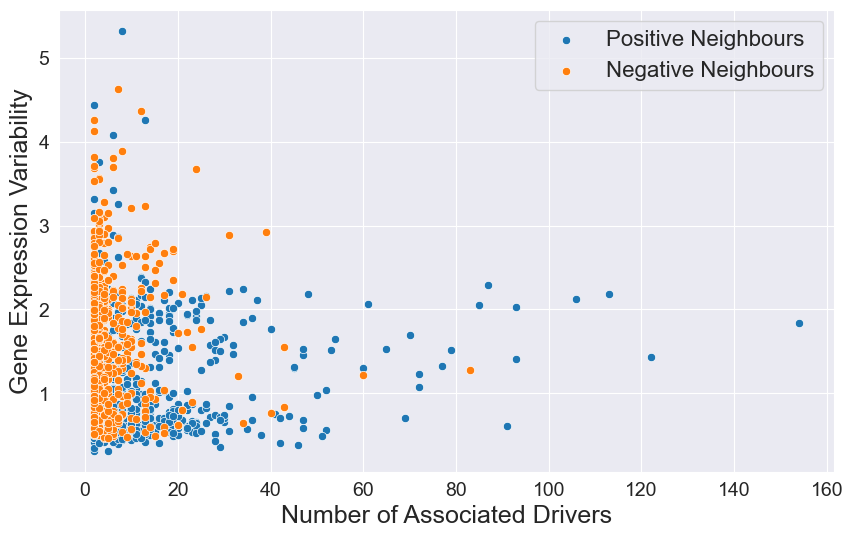

In [25]:
sns.set_style("darkgrid") 
# Define the colors for positive and negative neighbours
colors = {'Positive': '#1f77b4', 'Negative': '#ff7f0e'}

# Visualisation of correlation with consistent colors and larger font size
plt.figure(figsize=(10, 6))
sns.scatterplot(x=only_pos_variability['num_associated_drivers'], y=only_pos_variability['variability'], 
                label='Positive Neighbours', color=colors['Positive'])
sns.scatterplot(x=only_neg_variability['num_associated_drivers'], y=only_neg_variability['variability'], 
                label='Negative Neighbours', color=colors['Negative'])
plt.xlabel('Number of Associated Drivers', fontsize=18)
plt.ylabel('Gene Expression Variability', fontsize=18)
#plt.title('Correlation between Gene Expression Variability and Number of Associated Drivers', fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In the scatter plot above, most data points cluster around lower values for both variables, reinforcing the observation that variability in gene expression does not increase significantly with the number of associated drivers. Even among the neighbours that are associated with a greater number of drivers, the observed increase in variability is minimal and inconsistent across the two groups.

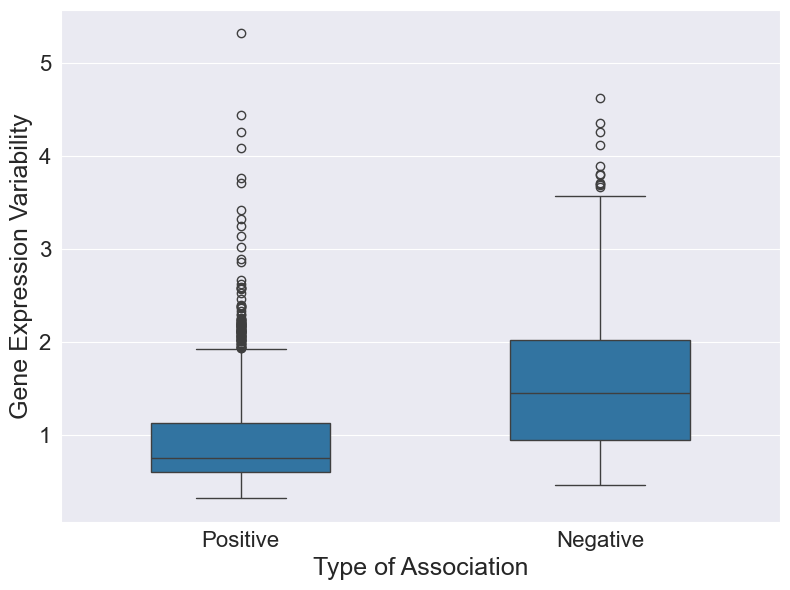

In [26]:
# Plot box plot for variability with larger font sizes
plt.figure(figsize=(8, 6))  # Adjust width to make the plot narrower

# Boxplot for association types (Positive and Negative) with narrower boxes
sns.boxplot(x='association_type', y='variability', data=variability_df, width=0.5)

# Increase font sizes
plt.xlabel('Type of Association', fontsize=18)   # X-axis label size
plt.ylabel('Gene Expression Variability', fontsize=18)   # Y-axis label size
#plt.title('Gene Expression Variability for Positive and Negative Neighbours', fontsize=20)   # Title size

# Increase font size for ticks
plt.xticks(fontsize=16)   # X-axis ticks size
plt.yticks(fontsize=16)   # Y-axis ticks size

# Show the plot
plt.tight_layout()
plt.show()

These boxplots show that negative neighbours display a wider range of variability compared to positive neighbours.

In [27]:
# In addition to examining variability, we compared the average and median gene expression levels of positive and negative neighbours.
mean_expression_positive = tumourexp[only_pos_variability.index].mean(axis=0)
mean_expression_negative = tumourexp[only_neg_variability.index].mean(axis=0)

mean_pos_exp = np.mean(mean_expression_positive)
mean_neg_exp = np.mean(mean_expression_negative)
median_pos_exp = np.median(mean_expression_positive)
median_neg_exp = np.median(mean_expression_negative)

print(f"\nMean gene expression (Positive Neighbours): {mean_pos_exp:.4f}")
print(f"Mean gene expression (Negative Neighbours): {mean_neg_exp:.4f}")
print(f"Median gene expression (Positive Neighbours): {median_pos_exp:.4f}")
print(f"Median gene expression (Negative Neighbours): {median_neg_exp:.4f}")


Mean gene expression (Positive Neighbours): 9.6482
Mean gene expression (Negative Neighbours): 8.0447
Median gene expression (Positive Neighbours): 9.7719
Median gene expression (Negative Neighbours): 8.4272


Positive neighbours exhibited significantly higher mean expression levels, with a mean expression of 9.6482 compared to 8.0447 for negative neighbours. The median expression levels followed a similar pattern, with positive neighbours showing a median of 9.7719 compared to 8.4272 for negative neighbours.

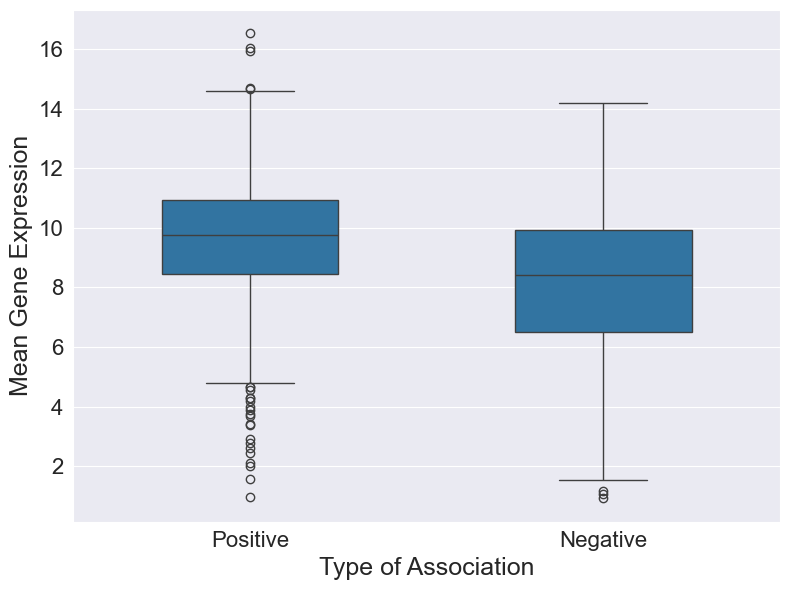


U-statistic for gene expression comparison: 403527.0
P-value for gene expression comparison: 3.758477797029196e-33
There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.


In [28]:
# Create a DataFrame for visualization
df_expression = pd.DataFrame({
    'Mean Expression': np.concatenate([mean_expression_positive, mean_expression_negative]),
    'Association Type': ['Positive'] * len(mean_expression_positive) + ['Negative'] * len(mean_expression_negative)
})

# Plot boxplot comparing mean expression levels between positive and negative neighbours
plt.figure(figsize=(8, 6)) 

sns.boxplot(x='Association Type', y='Mean Expression', data=df_expression, width=0.5)

# Increase font sizes for the plot
plt.xlabel('Type of Association', fontsize=18)  # X-axis label size
plt.ylabel('Mean Gene Expression', fontsize=18)  # Y-axis label size
#plt.title('Distribution of Mean Gene Expression for Positive and Negative Neighbours', fontsize=20)  # Title size

# Increase font size for ticks
plt.xticks(fontsize=16)  # X-axis ticks size
plt.yticks(fontsize=16)  # Y-axis ticks size

# Show the plot
plt.tight_layout()
plt.show()

# Statistical test to compare gene expression levels between positive and negative neighbours
u_stat_exp, p_value_exp = stats.mannwhitneyu(mean_expression_positive, mean_expression_negative)
print(f"\nU-statistic for gene expression comparison: {u_stat_exp}")
print(f"P-value for gene expression comparison: {p_value_exp}")
if p_value_exp < 0.05:
    print("There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.")
else:
    print("No statistically significant difference in mean gene expression levels between positive and negative neighbours.")

The difference in expression levels was confirmed to be statistically significant by a Mann-Whitney U test, yielding a U-statistic of 403527.0 and a p-value of $3.76 \times 10^{-33}$.

The boxplots show a clear distinction between the distribution of gene expression levels for positive and negative neighbours. Positive neighbours display higher expression levels overall, suggesting more consistent expression. Negative neighbours, while showing lower expression on average, exhibit a wider spread of values, indicating greater variability in their expression patterns.

Positive neighbours, being more stably and highly expressed, might play crucial roles in maintaining oncogenic signalling, while negative neighbours, exhibiting higher variability, could represent genes that are contextually important under
specific conditions.

### SIG VS NON SIG

Levene's Test: Statistics=19.50010380941732, p-value=1.0140250614527672e-05
P-value for homoscedasticity: 1.0140250614527672e-05
P-value for KS test (Significant): 0.0
P-value for KS test (Non-Significant): 0.0
Using Mann-Whitney U test:
U Statistic: 8308267.0
P-value: 5.043197301954638e-11


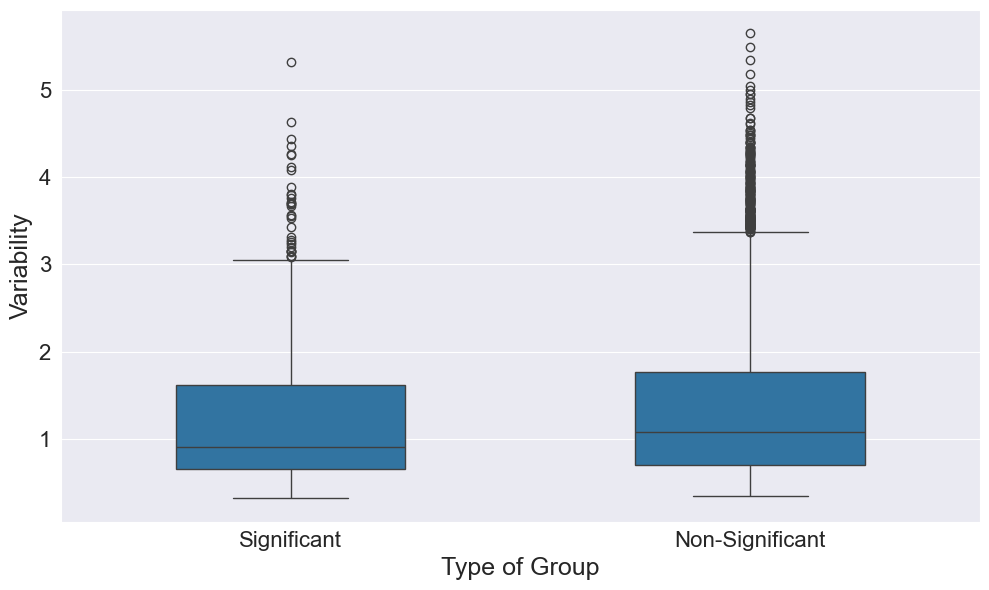

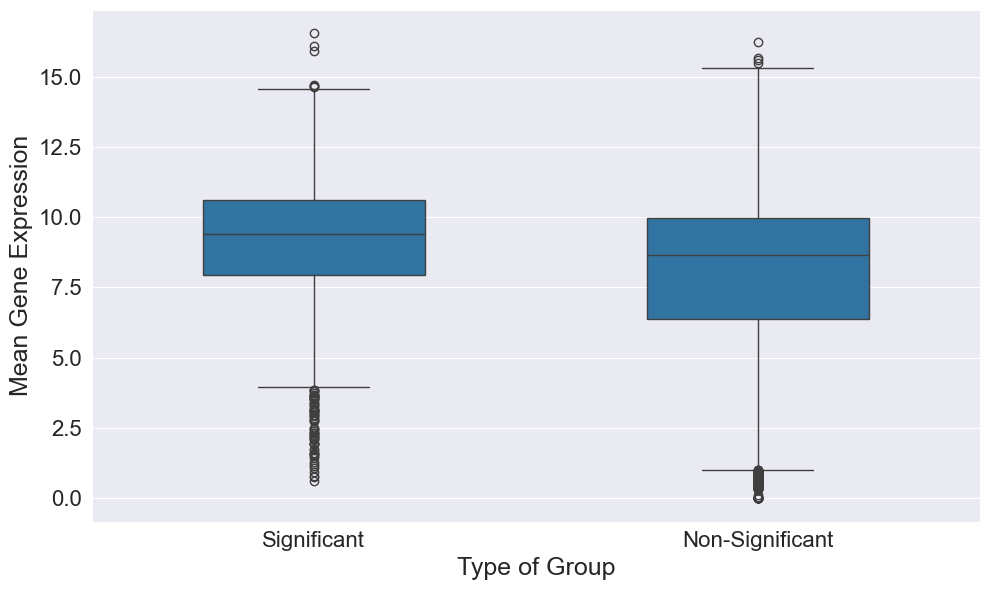


Summary Statistics:
Mean gene expression (Significant): 9.0901
Mean gene expression (Non-Significant): 7.9389
Median gene expression (Significant): 9.4150
Median gene expression (Non-Significant): 8.6500

Final Statistical Test Results:
U-statistic: 11273338.0
P-value: 1.3471231752589784e-46
Statistical significance: Significant difference in mean expression levels (p < 0.05)


In [29]:
def main() -> None:
    """
    Main function to execute the analysis pipeline.
    
    This function performs the following steps:
    1. Calculates variability for significant and non-significant neighbours
    2. Calculates mean expression for both groups
    3. Creates a DataFrame combining all metrics
    4. Performs statistical comparisons between groups
    5. Creates visualizations
    6. Prints summary statistics
    
    Notes:
        - Handles errors gracefully with appropriate error messages
        - Uses both parametric and non-parametric tests as appropriate
        - Creates visualizations for both variability and mean expression
        - Prints comprehensive summary statistics
    """
    try:
        # Calculate variability and mean expression for both groups
        variability_significant = [calculate_variability(tumourexp, neighbour) 
                                 for neighbour in significant_neighbours_filt]
        variability_non_significant = [calculate_variability(tumourexp, neighbour) 
                                     for neighbour in non_significant_neighbours_filt]
        
        mean_expression_significant = filt_neighbours[
            filt_neighbours['neighbour'].isin(significant_neighbours_filt)
        ]['expression'].tolist()
        mean_expression_non_significant = filt_neighbours[
            filt_neighbours['neighbour'].isin(non_significant_neighbours_filt)
        ]['expression'].tolist()
        
    except ValueError as e:
        print(f"Error in calculating variability or mean expression: {e}")
        return

    # Create combined DataFrame
    variability_df = pd.DataFrame({
        'neighbour': np.concatenate([significant_neighbours_filt, non_significant_neighbours_filt]),
        'variability': variability_significant + variability_non_significant,
        'group': ['Significant'] * len(variability_significant) + 
                ['Non-Significant'] * len(variability_non_significant),
        'mean_expression': mean_expression_significant + mean_expression_non_significant
    })

    # Perform statistical comparison
    compare_groups(variability_df)
    
    # Create visualizations
    plot_group_comparison(variability_df, 'variability', y_label='Variability', boxplot_width=0.5)
    plot_group_comparison(variability_df, 'mean_expression', y_label='Mean Gene Expression', 
                         boxplot_width=0.5)

    # Calculate and print summary statistics
    mean_sig = np.mean(mean_expression_significant)
    mean_non_sig = np.mean(mean_expression_non_significant)
    median_sig = np.median(mean_expression_significant)
    median_non_sig = np.median(mean_expression_non_significant)
    
    print("\nSummary Statistics:")
    print(f"Mean gene expression (Significant): {mean_sig:.4f}")
    print(f"Mean gene expression (Non-Significant): {mean_non_sig:.4f}")
    print(f"Median gene expression (Significant): {median_sig:.4f}")
    print(f"Median gene expression (Non-Significant): {median_non_sig:.4f}")

    # Perform final statistical test on expression levels
    sig_exp_levels = tumourexp[significant_neighbours_filt].mean(axis=0)
    non_sig_exp_levels = tumourexp[non_significant_neighbours_filt].mean(axis=0)
    
    u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, 
                                        alternative='two-sided')
    
    print("\nFinal Statistical Test Results:")
    print(f"U-statistic: {u_stat}")
    print(f"P-value: {p_value}")
    print("Statistical significance: " + 
          ("Significant difference in mean expression levels (p < 0.05)" 
           if p_value < 0.05 else 
           "No significant difference in mean expression levels (p >= 0.05)"))

if __name__ == "__main__":
    main()

Further analysis comparing significant and non-significant neighbours revealed that significant ones exhibit higher gene expression levels on average. Significant neighbours had a mean expression of 9.0901, while non-significant had a mean expression of 7.9389. The median expression levels followed this trend, with significant neighbours having a median expression of 9.4150 compared to 8.6500 for non-significant. A Mann-Whitney U test confirmed this difference to be statistically significant, with
a U-statistic of 11273338.0 and a p-value of $1.35 \times 10^{-46}$.

Both significant and non-significant neighbours display similar ranges in gene expression variability, with no substantial difference in the spread. However, despite the apparent overlap, the distribution of variability between the two groups was found to be statistically different. The Mann-Whitney U test revealed a highly significant p-value of $5.04 \times 10^{-11}$, indicating that the variability distribution between significant and non-significant neighbours is not entirely equivalent.

## Enrichment Analysis

To compare the functional annotations between significant and non-significant neighbours, as well as between positive and negative neighbours, we performed functional enrichment analysis using the g:Profiler tool. Enrichment analysis is a powerful statistical method used to identify biological features (such as Gene Ontology terms, pathways, or other functional categories) that are overrepresented in a given list of genes or proteins compared to a background set. This analysis is essential for understanding the biological significance of neighbour protein sets that are associated with cancer driver mutations.

In [30]:
hallmarks_df = pd.read_excel('hallmarks_to_goterms.xlsx')
hallmarks_df['Hallmarks'] = hallmarks_df['Hallmarks'].str.strip()
hallmarks_df['GO terms'] = hallmarks_df['GO terms'].str.strip()
hallmarks_df['Term name'] = hallmarks_df['Term name'].str.strip()

In [31]:
background = []
for net in networks:
    ppi = pd.read_csv(datadir + f"{net}_graph.csv")
    # Extract unique proteins from both columns of the PPI network
    gene_names = pd.concat([ppi.iloc[:, 0], ppi.iloc[:, 1]]).drop_duplicates().tolist()
    background.extend(gene_names)

# Remove duplicates to get the final background set
background = list(set(background))

print(f'Total number of unique proteins in background: {len(background)}')

Total number of unique proteins in background: 20142


The background set for our analysis consisted of 20142 genes, representing all unique proteins across five distinct PPI networks (HuRI, APID, BioGRID, STRING, and OmniPath).

Enriched terms were filtered to include only GO biological process (GO:BP) annotations associated with cancer hallmarks, based on the correspondence established in *Establishing a consensus for the hallmarks of cancer based on gene ontology and pathway annotations* (Chen, Verbeek, & Wolstencroft, 2021). This filtering step allows us to focus specifically on cancer-related processes, providing a more targeted analysis of how the different groups of neighbours relate to cancer biology.

References
- Chen, Y., Verbeek, F. J., & Wolstencroft, K. Establishing a consensus for the hallmarks of cancer based on gene ontology and pathway annotations. *BMC Bioinformatics*, 22, 178 (2021). https://doi.org/10.1186/s12859-021-04105-8

This analysis was based on two hypotheses: (1) non-significant neighbours would be less related to known cancer pathways and processes than significant neighbours, and (2) neighbours positively correlated with cancer drivers are more likely to participate in oncogenic pathways, while negatively correlated neighbours may not be directly involved in cancer-related ones. However, given that all neighbour proteins are direct interactors of cancer driver proteins, there remains a strong likelihood of overlap in functional annotations between neighbour and driver proteins.

#### POS VS NEG

In [32]:
only_pos = only_pos_variability.index.tolist()
only_neg = only_neg_variability.index.tolist()

In [33]:
print(len(only_pos))
print(len(only_neg))

1013
586


In [34]:
# Defining sources for enrichment
sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP"]

# Perform enrichment analysis for positive and negative neighbours
pos_enrichment = perform_enrichment(only_pos, background, sources)
neg_enrichment = perform_enrichment(only_neg, background, sources)

In [35]:
all_intersections_set = set()

for source in sources:
    # Include only GO:BP sources
    if source.startswith('GO:BP'):
        dic = pos_enrichment[source]
        dic_filt_pos = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set
        for intersection_list in dic_filt_pos['intersections']:
            all_intersections_set.update(intersection_list)

# Count how many values from only_pos appear in the set of intersections
count_only_pos_in_intersections = sum(1 for item in only_pos if item in all_intersections_set)

print(f"Number of values from only_pos that appear in the intersections: {count_only_pos_in_intersections}")
proportion = count_only_pos_in_intersections / len(only_pos) 
print(f"Proportion of values from only_pos that appear in the intersections: {proportion}")

Number of values from only_pos that appear in the intersections: 533
Proportion of values from only_pos that appear in the intersections: 0.5261599210266535


When analysing the fraction of neighbours in each set annotated with enriched GO terms, we found that 52.62% of positive neighbours (533 out of 1013) were associated with cancer hallmark processes, indicating significant participation in enriched GO terms.

In [36]:
# Convert only_pos to a set for faster lookup
only_pos_set = set(only_pos)

# Apply the function to count intersections and store in a new column
dic_filt_pos['only_pos_count'] = dic_filt_pos.apply(count_intersections, axis=1, only_pos_set=only_pos_set)

# Sort the DataFrame by 'only_pos_count' in descending order and reset the index
dic_filt_pos_sorted = dic_filt_pos[['native', 'only_pos_count']].sort_values('only_pos_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame
print(dic_filt_pos_sorted)

        native  only_pos_count
0   GO:0007049             317
1   GO:0012501             180
2   GO:0008283             158
3   GO:0051301             148
4   GO:0043067             140
5   GO:0006281             122
6   GO:0043069              80
7   GO:0045787              76
8   GO:0008284              75
9   GO:0045786              74
10  GO:0045786              74
11  GO:0050776              63
12  GO:0032200              48
13  GO:0000723              46
14  GO:0031570              35
15  GO:0006282              34
16  GO:0032204              28
17  GO:0045005              17
18  GO:0071456              17
19  GO:0090398              14
20  GO:2000772               7


For the positively correlated neighbours, 21 significantly enriched GO terms were identified.

In [37]:
all_intersections_set_neg = set()

for source in sources:
    # Include only GO:BP sources
    if source.startswith('GO:BP'):
        dic = neg_enrichment[source]
        dic_filt_neg = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_neg
        for intersection_list in dic_filt_neg['intersections']:
            all_intersections_set_neg.update(intersection_list)

# Count how many values from only_neg appear in the set of intersections
count_only_neg_in_intersections = sum(1 for item in only_neg if item in all_intersections_set_neg)

print(f"Number of values from only_neg that appear in the intersections: {count_only_neg_in_intersections}")
proportion = count_only_neg_in_intersections / len(only_neg) 
print(f"Proportion of values from only_neg that appear in the intersections: {proportion}")

Number of values from only_neg that appear in the intersections: 347
Proportion of values from only_neg that appear in the intersections: 0.5921501706484642


For negative neighbours, 59.21% (347 out of 586) were involved, indicating a slightly higher proportion of negative neighbours engaged in these biological processes.

In [38]:
only_neg_set = set(only_neg)

# Apply the function to count intersections and store in a new column
dic_filt_neg['only_neg_count'] = dic_filt_neg.apply(count_intersections, axis=1, only_pos_set=only_neg_set)

# Sort the DataFrame by 'only_neg_count' in descending order and reset the index
dic_filt_neg_sorted = dic_filt_neg[['native', 'only_neg_count']].sort_values('only_neg_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean index
print(dic_filt_neg_sorted)

        native  only_neg_count
0   GO:0008283             130
1   GO:0030030             124
2   GO:0012501             104
3   GO:0016477             102
4   GO:0007155              93
5   GO:0043067              89
6   GO:0007049              82
7   GO:0034330              75
8   GO:0008284              71
9   GO:0009968              65
10  GO:0043069              52
11  GO:0030155              48
12  GO:0001525              45
13  GO:0008285              43
14  GO:0050727              21
15  GO:0045787              19
16  GO:0045766              16
17  GO:0030307              15
18  GO:0030308              15
19  GO:0001837              13
20  GO:0001570              11
21  GO:0071456              11
22  GO:0090398               9


For negatively correlated neighbours, 23 enriched GO terms were identified.

In [39]:
# Create DataFrames with native and proportions
pos_proportions = dic_filt_pos[['native', 'only_pos_count']].copy()
neg_proportions = dic_filt_neg[['native', 'only_neg_count']].copy()

# Calculate proportions
pos_proportions['pos_proportion'] = pos_proportions['only_pos_count'] / len(only_pos)
neg_proportions['neg_proportion'] = neg_proportions['only_neg_count'] / len(only_neg)

# Merge the two DataFrames on 'native' column
combined_proportions = pd.merge(
    pos_proportions[['native', 'pos_proportion']], 
    neg_proportions[['native', 'neg_proportion']], 
    on='native', 
    how='outer'
)

# Fill NaN values with 0
combined_proportions = combined_proportions.fillna(0)

# Add the 'name' column from the hallmarks_df to the merged dataframe
combined_proportions_2 = pd.merge(
    combined_proportions,
    hallmarks_df[['Hallmarks', 'GO terms', 'Term name']].rename(columns={'GO terms': 'native', 'Term name': 'name'}),
    on='native',
    how='left'
)

# Convert proportions to percentages
combined_proportions_2['Positive Proportion (%)'] = combined_proportions_2['pos_proportion'] * 100
combined_proportions_2['Negative Proportion (%)'] = combined_proportions_2['neg_proportion'] * 100

# Sort the merged dataframe and drop duplicates based on both 'native' and 'Hallmarks'
combined_proportions_sorted_2 = combined_proportions_2[['native', 'name', 'Positive Proportion (%)', 'Negative Proportion (%)', 'Hallmarks']].sort_values(
    ['Positive Proportion (%)', 'Negative Proportion (%)'], 
    ascending=False
).drop_duplicates(subset=['native', 'Hallmarks']).reset_index(drop=True)

#drop hallmarks column
#combined_proportions_sorted_2.drop('Hallmarks', axis=1, inplace=True)

# Print the sorted DataFrame to view the table
print(combined_proportions_sorted_2)

        native                                               name  \
0   GO:0007049                                         Cell Cycle   
1   GO:0012501                              Programmed cell death   
2   GO:0008283                                 Cell Proliferation   
3   GO:0051301                                      Cell Division   
4   GO:0043067                Regulation of programmed cell death   
5   GO:0006281                                         DNA repair   
6   GO:0043069       Negative regualtion of programmed cell death   
7   GO:0045787                  Positive regulation of cell cycle   
8   GO:0008284          Positive regulation of cell proliferation   
9   GO:0045786                  Negative regulation of cell cycle   
10  GO:0045786                  Negative regulation of cell cycle   
11  GO:0050776                      Regulation of immune response   
12  GO:0032200                              Telomere organization   
13  GO:0000723                    

In [40]:
terms_pos = dic_filt_pos['native'].tolist()
terms_neg = dic_filt_neg['native'].tolist()
terms_pos_set = set(terms_pos)
terms_neg_set = set(terms_neg)
intersection = terms_pos_set.intersection(terms_neg_set)
print(intersection)

{'GO:0090398', 'GO:0045787', 'GO:0012501', 'GO:0008283', 'GO:0043067', 'GO:0008284', 'GO:0071456', 'GO:0043069', 'GO:0007049'}


A total of 10 GO terms were shared between positive and negative neighbours, although the proportion of gene involvement varied between the groups.

These overlapping terms indicate that while both groups participate in common biological processes, their relative contribution for these terms can be different. Positive neighbours tend to be more involved in processes like cell proliferation, cell cycle progression, DNA repair, and immune response. Negative neighbours, on the other hand, are more frequently associated with cell migration, adhesion, and vascular development, while also showing involvement in programmed cell death regulation.

These findings challenge the initial hypothesis that positive neighbours would be more enriched in cancer hallmark pathways. This emphasises the importance of considering both positive and negative neighbours in understanding cancer biology.

#### SIG VS NON SIG

In addition to analysing positive and negative neighbours, we performed enrichment analysis by separating neighbours into significant and non-significant groups based on their association with cancer drivers.

In [41]:
# Perform enrichment for significant and non-significant neighbours
sig_enrichment_filt = perform_enrichment(significant_neighbours_filt, background, sources)
non_sig_enrichment_filt = perform_enrichment(list(non_significant_neighbours_filt), background, sources)

In [42]:
all_intersections_set_sig_filt = set()

for source in sources:
    # Include only GO:BP sources
    if source.startswith('GO:BP'):
        dic = sig_enrichment_filt[source]
        dic_filt_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_sig
        for intersection_list in dic_filt_sig['intersections']:
            all_intersections_set_sig_filt.update(intersection_list)

# Count how many values from significant_neighbours appear in the set of intersections
count_only_sig_in_intersections = sum(1 for item in significant_neighbours_filt if item in all_intersections_set_sig_filt)

print(f"Number of values from significant_neighbours that appear in the intersections: {count_only_sig_in_intersections}")
proportion = count_only_sig_in_intersections / len(significant_neighbours_filt) 
print(f"Proportion of values from significant_neighbours that appear in the intersections: {proportion}")

Number of values from significant_neighbours that appear in the intersections: 975
Proportion of values from significant_neighbours that appear in the intersections: 0.604089219330855


The enrichment analysis revealed that 60.41% of significant neighbours were annotated with enriched GO terms associated with hallmarks of cancer. 

In [43]:
# Apply the function to count intersections and store in a new column
dic_filt_sig['only_sig_count'] = dic_filt_sig.apply(count_intersections, axis=1, only_pos_set=significant_neighbours_filt)

# Sort the DataFrame by 'only_sig_count' in descending order and reset the index
dic_filt_sig_sorted = dic_filt_sig[['native', 'only_sig_count']].sort_values('only_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_filt_sig_sorted)

        native  only_sig_count
0   GO:0007049             404
1   GO:0008283             293
2   GO:0012501             291
3   GO:0043067             236
4   GO:0030030             187
5   GO:0051301             175
6   GO:0006955             169
7   GO:0016477             162
8   GO:0007155             152
9   GO:0008284             149
10  GO:0009968             140
11  GO:0006281             138
12  GO:0043069             136
13  GO:0050776              97
14  GO:0034330              96
15  GO:0045787              96
16  GO:0030155              93
17  GO:0045786              92
18  GO:0045786              92
19  GO:0008285              89
20  GO:0001525              72
21  GO:0032200              51
22  GO:0000723              48
23  GO:0006282              44
24  GO:0031570              39
25  GO:0032204              30
26  GO:0071456              28
27  GO:0090398              23
28  GO:0030307              23
29  GO:0045766              22
30  GO:0045005              18
31  GO:0

For significant neighbours, 33 significantly enriched GO terms were identified.

In [44]:
all_intersections_set_n_sig_filt = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = non_sig_enrichment_filt[source]
        dic_filt_n_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                  left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_n_sig
        for intersection_list in dic_filt_n_sig['intersections']:
            all_intersections_set_n_sig_filt.update(intersection_list)

# Count how many values from non_significant_neighbours appear in the set of intersections
count_only_n_sig_in_intersections = sum(1 for item in non_significant_neighbours_filt if item in all_intersections_set_n_sig_filt)

print(f"Number of values from non_significant_neighbours that appear in the intersections: {count_only_n_sig_in_intersections}")
proportion = count_only_n_sig_in_intersections / len(non_significant_neighbours_filt) 
print(f"Proportion of values from non_significant_neighbours that appear in the intersections: {proportion}")

Number of values from non_significant_neighbours that appear in the intersections: 4482
Proportion of values from non_significant_neighbours that appear in the intersections: 0.3914410480349345


39.14% of non-significant neighbours were annotated with enriched GO terms associated with hallmarks of cancer. This indicates that significant neighbours have a stronger representation in key cancer related pathways compared to their non-significant counterparts.

In [45]:
dic_filt_n_sig['only_n_sig_count'] = dic_filt_n_sig.apply(count_intersections, axis=1, only_pos_set=non_significant_neighbours_filt)

# Sort the DataFrame by 'only_n_sig_count' in descending order and reset the index
dic_filt_n_sig_sorted = dic_filt_n_sig[['native', 'only_n_sig_count']].sort_values('only_n_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_filt_n_sig_sorted)

        native  only_n_sig_count
0   GO:0012501              1332
1   GO:0008283              1280
2   GO:0006955              1168
3   GO:0007155              1067
4   GO:0016477              1044
5   GO:0030030              1037
6   GO:0043067               995
7   GO:0009968               922
8   GO:0050776               630
9   GO:0008284               609
10  GO:0043069               587
11  GO:0030155               579
12  GO:0034330               511
13  GO:0008285               468
14  GO:0001525               383
15  GO:0050727               261
16  GO:0007162               217
17  GO:0030308               131
18  GO:0045766               122
19  GO:0001837               121
20  GO:0030307               108
21  GO:0002367                94
22  GO:0090398                70
23  GO:0006096                65


For non-significant neighbours, 24 enriched GO terms were identified

In [46]:
# Create DataFrames with native and proportions
sig_proportions = dic_filt_sig[['native', 'only_sig_count']].copy()
n_sig_proportions = dic_filt_n_sig[['native', 'only_n_sig_count']].copy()

# Calculate proportions
sig_proportions['sig_proportion'] = sig_proportions['only_sig_count'] / len(significant_neighbours_filt)
n_sig_proportions['n_sig_proportion'] = n_sig_proportions['only_n_sig_count'] / len(non_significant_neighbours_filt)

# Merge the two DataFrames on 'native' column
combined_proportions_sig = pd.merge(
    sig_proportions[['native', 'sig_proportion']], 
    n_sig_proportions[['native', 'n_sig_proportion']], 
    on='native', 
    how='outer'
)

# Fill NaN values with 0
combined_proportions_sig = combined_proportions_sig.fillna(0)

# Add the 'name' column from the hallmarks_df to the merged dataframe
combined_proportions_sig_2 = pd.merge(
    combined_proportions_sig,
    hallmarks_df[['Hallmarks', 'GO terms', 'Term name']].rename(columns={'GO terms': 'native', 'Term name': 'name'}),
    on='native',
    how='left'
)

# Convert proportions to percentages
combined_proportions_sig_2['Sig Proportion (%)'] = combined_proportions_sig_2['sig_proportion'] * 100
combined_proportions_sig_2['Non-Sig Proportion (%)'] = combined_proportions_sig_2['n_sig_proportion'] * 100

# Sort the merged dataframe and drop duplicates based on both 'native' and 'Hallmarks'
combined_proportions_sorted_sig_2 = combined_proportions_sig_2[['native', 'name', 'Sig Proportion (%)', 'Non-Sig Proportion (%)', 'Hallmarks']].sort_values(
    ['Sig Proportion (%)', 'Non-Sig Proportion (%)'], 
    ascending=False
).drop_duplicates(subset=['native', 'Hallmarks']).reset_index(drop=True)

#drop hallmarks column
combined_proportions_sorted_sig_2.drop('Hallmarks', axis=1, inplace=True)

# Print the sorted DataFrame to view the table
print(combined_proportions_sorted_sig_2)

        native                                               name  \
0   GO:0007049                                         Cell Cycle   
1   GO:0008283                                 Cell Proliferation   
2   GO:0012501                              Programmed cell death   
3   GO:0043067                Regulation of programmed cell death   
4   GO:0030030                       Cell projection Organization   
5   GO:0051301                                      Cell Division   
6   GO:0006955                                    Immune Response   
7   GO:0016477                                     Cell migration   
8   GO:0007155                                      Cell adhesion   
9   GO:0008284          Positive regulation of cell proliferation   
10  GO:0009968         Negative regulation of signal transduction   
11  GO:0006281                                         DNA repair   
12  GO:0043069       Negative regualtion of programmed cell death   
13  GO:0050776                    

In [47]:
terms_sig = dic_filt_sig['native'].tolist()
terms_n_sig = dic_filt_n_sig['native'].tolist()
terms_sig_set = set(terms_sig)
terms_n_sig_set = set(terms_n_sig)
intersection = terms_sig_set.intersection(terms_n_sig_set)
print(intersection)
print(len(intersection))

{'GO:0006955', 'GO:0043067', 'GO:0030030', 'GO:0008285', 'GO:0009968', 'GO:0030155', 'GO:0034330', 'GO:0012501', 'GO:0008283', 'GO:0008284', 'GO:0007155', 'GO:0006096', 'GO:0090398', 'GO:0030307', 'GO:0016477', 'GO:0050776', 'GO:0001525', 'GO:0043069', 'GO:0045766'}
19


There are 19 GO:BP terms that are enriched in both groups. This indicates that there are biological processes shared between the two groups, but also significant differences.

All the shared terms have higher proportions in significant neighbours, with more pronounced differences, suggesting a more distinct functional separation between these groups than initially thought. These variations further emphasise the distinct biological functions that each group plays in cancer-related processes.

## TAU

The Tau Tissue Specificity Index is a numerical measure ranging from 0 to 1, offering a robust and continuous metric for gene expression specificity across tissues. A tau value close to 0 indicates ubiquitous expression, suggesting that the gene is expressed at comparable levels across multiple tissues. Conversely, a tau value near 1 reflects high tissue specificity, signifying that the gene is primarily expressed in one or a few tissues.

Gene expression patterns are often classified into two major categories: housekeeping genes and tissue-specific genes. Housekeeping genes are critical for maintaining basic cellular functions and are expressed across all tissue types and cells. In contrast, tissue-specific genes are predominantly expressed in a single tissue, often associated with specific cell functions and phenotypes.

However, not all genes fit neatly into these two categories. A third group consists of genes with midrange expression, characterised by high expression in certain tissues and low or no expression in others. Moreover, advancements in high-throughput gene expression technologies have shown that many genes previously thought to be tissue-specific also exhibit background expression in multiple tissues. 

We hypothesised that driver gene neighbours (i.e., significant vs.non-significant and positive vs. negative) could be distinguished based on the tissue specificity of their gene expression.

#### POS VS NEG

In [51]:
# Load TAU data
tau_df = pd.read_csv('gene_exp.csv')
tau_df = tau_df.set_index('gene_id')
tau_df_filtered = tau_df[~tau_df.index.duplicated(keep='first')]

# Obtain TAU values for positive and negative neighbours
pos_tau = tau_df_filtered.loc[tau_df_filtered.index.isin(only_pos), 'tau']
neg_tau = tau_df_filtered.loc[tau_df_filtered.index.isin(only_neg), 'tau']

# Mann-Whitney U test for comparison of TAU between positive and negative neighbours
u_stat_tau, p_value_tau = stats.mannwhitneyu(pos_tau, neg_tau)
print(f"\nComparison of TAU between positive-only and negative-only neighbours:")
print(f"U-statistic: {u_stat_tau}")
print(f"P-value: {p_value_tau}")

# Correlation between association counts and TAU
neighbour_counts_with_tau = consistent_neighbours.reset_index().merge(tau_df_filtered[['tau']], left_on='neighbour', right_index=True, how='left')
correlation = neighbour_counts_with_tau['num_associated_drivers'].corr(neighbour_counts_with_tau['tau'])
print(f"\nCorrelation between association counts and TAU: {correlation}")


Comparison of TAU between positive-only and negative-only neighbours:
U-statistic: 204543.5
P-value: 3.7824477955517745e-24

Correlation between association counts and TAU: 0.07698776612295498


A statistically significant difference was observed between the positive and negative neighbours of cancer driver genes. The results of the Mann-Whitney U test (p-value = $3.782 \times 10^{-24}$), demonstrate a highly significant distinction between these groups.

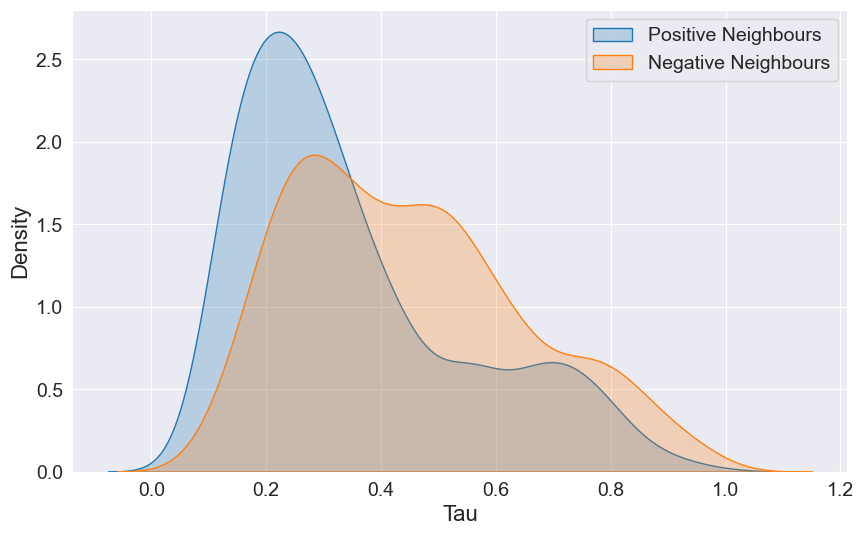

In [52]:
plt.figure(figsize=(10, 6))
sns.kdeplot(pos_tau, fill=True, label='Positive Neighbours', color='#1f77b4')  # Custom color for Positive Neighbours
sns.kdeplot(neg_tau, fill=True, label='Negative Neighbours', color='#ff7f0e')  # Custom color for Negative Neighbours
plt.xlabel('Tau', fontsize=16)
plt.ylabel('Density', fontsize=16)
#plt.title('Distribution of Tau for Positive and Negative Neighbours', fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

A detailed examination of the Tau distributions reveals that negative neighbours exhibit higher tau values compared to positive neighbours. This suggests that negative neighbours exhibit greater tissue specificity in their expression patterns.

#### SIG VS NON SIG

In [53]:
significant_neighbours_filt_set = set(significant_neighbours_filt)
non_significant_neighbours_filt_set = set(non_significant_neighbours_filt)

# Create sets of neighbours that exist in tau_df
significant_neighbours_filt_tau = significant_neighbours_filt_set.intersection(tau_df_filtered.index)
non_significant_neighbours_filt_tau = non_significant_neighbours_filt_set.intersection(tau_df_filtered.index)

# Convert the sets back to lists for indexing
significant_neighbours_filt_list = list(significant_neighbours_filt_tau)
non_significant_neighbours_filt_list = list(non_significant_neighbours_filt_tau)

# Obtain the tau values for significant and non-significant neighbours
sig_tau_filt = tau_df_filtered.loc[significant_neighbours_filt_list, 'tau']
non_sig_tau_filt = tau_df_filtered.loc[non_significant_neighbours_filt_list, 'tau']

# Perform the Mann-Whitney U test
u_stat, u_p_value = stats.mannwhitneyu(sig_tau_filt, non_sig_tau_filt)

print("\nComparison of TAU between significant and non-significant neighbours:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {u_p_value}")


Comparison of TAU between significant and non-significant neighbours:
U-statistic: 7617976.5
P-value: 7.275591615971163e-26


The Mann-Whitney U test revealed a highly significant difference in the distribution of tau values between significant and non-significant neighbours (p-value = $7.276 \times 10^{-26}$).

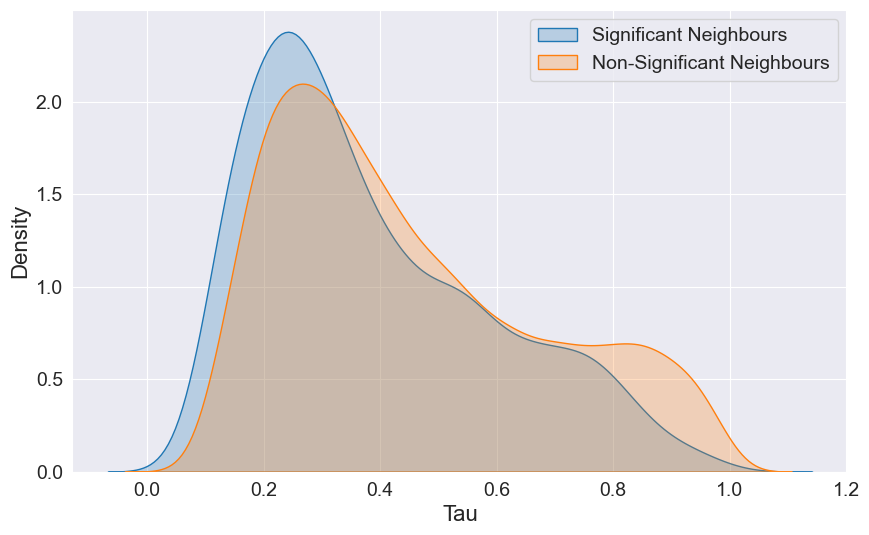

In [54]:
plt.figure(figsize=(10, 6))
sns.kdeplot(sig_tau_filt, fill=True, label='Significant Neighbours', color='#1f77b4')  # Custom color for Significant Neighbours
sns.kdeplot(non_sig_tau_filt, fill=True, label='Non-Significant Neighbours', color='#ff7f0e')  # Custom color for Non-Significant Neighbours
plt.xlabel('Tau', fontsize=16)
plt.ylabel('Density', fontsize=16)
#plt.title('Distribution of Tau for Significant and Non-Significant Neighbours', fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Non-significant neighbours tend to exhibit slightly higher tau values compared to significant neighbours. This suggests that non-significant neighbours are generally more tissue-specific in their expression patterns.

In [55]:
overlap = overlap_coefficient(sig_tau_filt, non_sig_tau_filt)
print(f"Overlap coefficient: {overlap}")

#For the overlap coefficient, values close to 1 indicate high overlap, while values close to 0 indicate low overlap.

Overlap coefficient: 0.9993777224642191


However, the overlap in the two distributions is substantial (overlap coefficient of 0.9994), suggesting that the overall difference in tissue specificity between the two groups is relatively small.

## Kaplan-Meier Survival Analysis

Kaplan-Meier survival analysis was performed to assess whether the expression levels of significant neighbour genes have a statistically significant impact on patient survival outcomes. This analysis provides insights into the prognostic relevance of neighbours consistently associated with cancer driver genes, particularly in relation to overall survival.

In this analysis, we focused on analysing neighbours that are not listed in the NCG<sup>HD</sup> dataset (out of a total of 1614 neighbours having at least two significant interactions, 1210 were not present). 

In [57]:
# Load the NCG file
cancerdrivers = pd.read_table('NCG_cancerdrivers_annotation_supporting_evidence.tsv')

# Filter the neighbours that are not in the NCG
non_ncg_neighbours = dints[~dints['neighbour'].isin(cancerdrivers['symbol'])]
print(f"Number of neighbours not present in the NCG: {non_ncg_neighbours['neighbour'].nunique()}")

Number of neighbours not present in the NCG: 2345


In [58]:
# Filters out significant neighbours that are not in the NCG file
non_ncg_neighbours = filt_neighbours[
    filt_neighbours['neighbour'].isin(significant_neighbours_filt) & 
    ~filt_neighbours['neighbour'].isin(cancerdrivers['symbol'])
]

print(f"Number of significant neighbours not present in the NCG: {non_ncg_neighbours['neighbour'].nunique()}")

# Out of a total of 1614 neighbours having at least two significant interactions, 1210 were not present in the NCG database.

Number of significant neighbours not present in the NCG: 1210


To ensure the robustness of our findings, we first evaluated the sign consistency of coefficients for each neighbour across different drivers. We retained only those neighbours with consistent coefficient signs and then ranked these neighbours by the number of associated drivers, selecting the top 50 for further analysis. Each neighbour was classified as either ’Positive’ or ’Negative’ based on its correlation with the status of driver gene mutation, as determined by the sign of its coefficients obtained from linear regression models and Spearman’s correlation analysis.

In [59]:
# Keep just the neighbours with the consistency of the sign (pos_dints = 0 or neg_dints = 0)
consistent_neighbours = non_ncg_neighbours[(non_ncg_neighbours['pos_dints'] == 0) | (non_ncg_neighbours['neg_dints'] == 0)]

# Kepp the columns with the number of associated drivers and the type of association
consistent_neighbours = consistent_neighbours[['neighbour', 'n_dints', 'group']].rename(columns={'n_dints': 'num_associated_drivers', 'group': 'association_type'})
consistent_neighbours['association_type'] = consistent_neighbours['association_type'].map({'pos': 'Positive', 'neg': 'Negative'})

# Sort by the number of associated drivers (descending) and select the top 50
top_50_neighbours_filt = consistent_neighbours.sort_values('num_associated_drivers', ascending=False).head(50)

# Display the top 50 neighbours
print(top_50_neighbours_filt)

      neighbour  num_associated_drivers association_type
1863       CDK1                     154         Positive
1685       CCNF                     122         Positive
5517      KIF14                     113         Positive
5527     KIF20A                     106         Positive
10641     STIP1                      91         Positive
969       AURKB                      87         Positive
5532      KIF23                      85         Positive
5852      LMNB1                      79         Positive
1874       CDK2                      72         Positive
4918   HSP90AA1                      69         Positive
1674      CCNB1                      65         Positive
5639      KPNA2                      60         Positive
8384       PRC1                      53         Positive
2026      CHEK1                      52         Positive
12354     XRCC6                      51         Positive
7671       PCNA                      50         Positive
1944      CENPA                

We then integrated the expression data of the top 50 selected neighbours with patient survival data to generate a comprehensive dataset for Kaplan-Meier survival analysis.

In [60]:
# Select the tumour expression data for non-NCG neighbours
selected_tumourexp_filt = tumourexp.reset_index()[['patient', 'cancer_type'] + top_50_neighbours_filt['neighbour'].tolist()]

# Load the survival data
clintab = pd.read_table('Survival_SupplementalTable_S1_20171025_xena_sp')
survival_data = clintab[['_PATIENT', 'OS.time', 'OS']]

# Merge the expression data with the survival data
final_data_filt = selected_tumourexp_filt.merge(survival_data, left_on='patient', right_on='_PATIENT', how='inner')

# Remove the duplicate 'sample' column
final_data_filt = final_data_filt.drop(columns=['_PATIENT'])
final_data_filt

,patient,cancer_type,CDK1,CCNF,KIF14,KIF20A,STIP1,AURKB,KIF23,LMNB1,...,TUBG1,DCPS,SPAG5,E2F1,FANCI,SHMT2,SNCA,RRM2,OS.time,OS
0,TCGA-02-0047,GBM,9.07,8.12,7.30,8.28,11.33,7.67,7.59,9.96,...,9.30,7.87,8.60,8.52,8.92,10.51,9.81,9.64,448.0,1.0
1,TCGA-02-0055,GBM,9.09,7.62,6.43,8.10,11.93,7.46,8.53,8.87,...,9.70,8.26,8.34,8.38,8.87,10.81,9.15,10.15,76.0,1.0
2,TCGA-02-2483,GBM,10.07,9.01,8.31,8.97,12.19,9.89,9.37,11.28,...,10.22,8.52,10.13,10.73,10.72,12.35,6.77,11.07,466.0,0.0
3,TCGA-02-2485,GBM,9.32,8.18,7.43,8.27,11.67,8.19,8.67,10.93,...,9.84,9.12,9.53,9.93,9.88,10.34,7.50,9.95,470.0,0.0
4,TCGA-02-2486,GBM,6.30,5.98,4.31,5.00,11.53,4.07,5.30,7.71,...,9.81,8.31,6.01,7.33,7.52,10.85,8.63,7.49,618.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9622,TCGA-ZS-A9CG,LIHC,5.27,4.86,4.48,2.84,11.89,3.94,2.84,6.44,...,9.06,7.77,5.67,6.74,6.18,12.82,2.97,6.65,341.0,0.0
9623,TCGA-ZT-A8OM,THYM,10.33,10.94,6.61,7.27,12.15,11.86,8.30,9.95,...,9.84,9.40,10.46,11.14,11.69,11.47,6.19,11.68,1398.0,0.0
9624,TCGA-ZU-A8S4,CHOL,10.28,9.24,8.19,9.61,12.43,9.72,9.63,10.34,...,10.97,9.17,10.35,9.65,9.61,11.37,8.68,10.27,98.0,1.0
9625,TCGA-ZU-A8S4,CHOL,10.28,9.24,8.19,9.61,12.43,9.72,9.63,10.34,...,10.97,9.17,10.35,9.65,9.61,11.37,8.68,10.27,98.0,1.0


In [61]:
print(final_data_filt.isnull().sum())

patient         0
cancer_type     0
CDK1            0
CCNF            0
KIF14           0
KIF20A          0
STIP1           0
AURKB           0
KIF23           0
LMNB1           0
CDK2            0
HSP90AA1        0
CCNB1           0
KPNA2           0
PRC1            0
CHEK1           0
XRCC6           0
PCNA            0
CENPA           0
TRIM25          0
UBE2T           0
MTA2            0
UBE2S           0
MCM2            0
LRRC59          0
OBSL1           0
RAN             0
PFN1            0
HDAC5           0
RAD51           0
UBE2I           0
GTSE1           0
TMPO            0
CCNA2           0
TFRC            0
MAD2L1          0
CEP55           0
LYAR            0
SSRP1           0
CSK             0
SNRPD1          0
DNAJC9          0
KIF11           0
C1QBP           0
TUBG1           0
DCPS            0
SPAG5           0
E2F1            0
FANCI           0
SHMT2           0
SNCA            0
RRM2            0
OS.time        32
OS              0
dtype: int64


To ensure the accuracy of the analysis, individuals with missing data on overall survival time or overall survival status were excluded, preserving data integrity.

In [62]:
final_data_filt.dropna(subset=['OS.time', 'OS'], inplace=True)

### Survival Analysis

By categorising patients into high and low neighbour gene expression groups, Kaplan-Meier analysis enables a comparison of survival curves between these groups. This method reveals how gene expression influences patient prognosis, potentially identifying neighbours whose overexpression correlates with poorer survival outcomes. Such findings are critical for identifying candidate genes for therapeutic intervention, as genes linked to worse survival outcomes often play key roles in tumour progression or
cancer aggressiveness.

The Kaplan-Meier method, combined with log-rank tests, offers robust statistical validation of the results. The significant survival differences observed between high and low expression groups support the hypothesis that these neighbours contribute to tumour progression and are clinically relevant. These results reinforce the broader hypothesis of this study, which posits that driver-neighbour interactions play a crucial role in tumour biology.

Significant Results:
Cancer Type: ACC, Neighbour: CDK1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF14, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF20A, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: AURKB, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF23, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: LMNB1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CDK2, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: CCNB1, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: KPNA2, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: PRC1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CHEK1, Compa

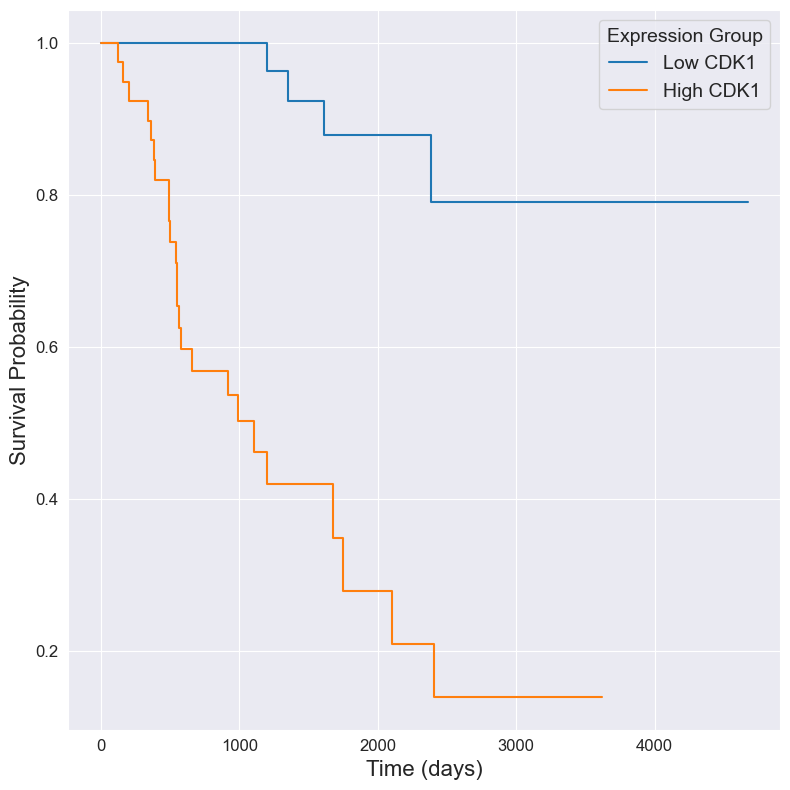

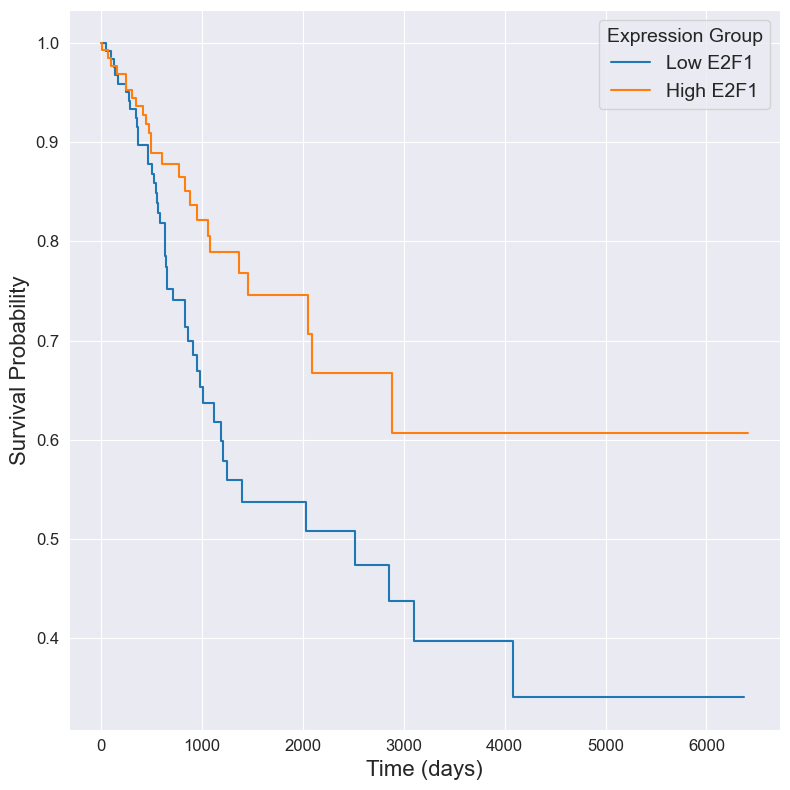

In [63]:
top_neighbours_filt = top_50_neighbours_filt['neighbour'].tolist()

# The Kaplan-Meier analysis was applied separately across multiple cancer types, allowing the identification of genes that consistently affect survival in multiple cancers, underscoring their fundamental role in oncogenesis.
significant_results = []
grouped_data = final_data_filt.groupby('cancer_type')
expression_groups = ['Low_Expression', 'High_Expression']

for cancer_type, group_data in grouped_data:
    for neighbour in top_neighbours_filt:
        # Prepare data for Kaplan-Meier analysis
        neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
        # Patients were stratified into two groups based on the median expression level of each neighbour gene
        neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
        neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()
        
        # Perform survival analysis and get p-values and median survival times
        p_values, median_survival = kaplan_meier_survival(neighbour_data, 'OS', expression_groups)
        
        for comparison, p_value in p_values.items():
            # Significant results were identified based on a p-value threshold of <0.05
            if p_value < 0.05:
                low_median = median_survival['Low_Expression']
                high_median = median_survival['High_Expression']
                trend = "increase" if high_median > low_median else "decrease"
                significant_results.append((cancer_type, neighbour, comparison, p_value, trend))

# Print significant results
print("Significant Results:")
for result in significant_results:
    print("Cancer Type: {}, Neighbour: {}, Comparison: {}, p-value: {:.4f}, Trend: {}".format(*result))

# Generate plots for significant results
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    # Filter data for the specific cancer type and neighbour gene 
    if cancer_type == 'ACC' and neighbour == 'CDK1' or cancer_type == 'CESC' and neighbour == 'E2F1':
        group_data = grouped_data.get_group(cancer_type)
        neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
        neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
        neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()

        plot_significant_kaplan_meier(neighbour_data, 'OS', neighbour, cancer_type)

Kaplan-Meier survival curves were generated for each neighbour gene, across various cancer types, to compare survival outcomes between patients with high and low expression levels of the respective genes.

In [64]:
neighbour_trends = {}
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = []
    neighbour_trends[neighbour].append((cancer_type, trend))

print("\nNeighbour Trends:")
for neighbour, trends in neighbour_trends.items():
    print(f"Neighbour: {neighbour}")
    for cancer_type, trend in trends:
        print(f"  Cancer Type: {cancer_type}, Trend: {trend}")


Neighbour Trends:
Neighbour: CDK1
  Cancer Type: ACC, Trend: decrease
  Cancer Type: BRCA, Trend: decrease
  Cancer Type: KICH, Trend: decrease
  Cancer Type: KIRC, Trend: decrease
  Cancer Type: KIRP, Trend: decrease
  Cancer Type: LGG, Trend: decrease
  Cancer Type: LIHC, Trend: decrease
  Cancer Type: LUAD, Trend: decrease
  Cancer Type: MESO, Trend: decrease
  Cancer Type: PAAD, Trend: decrease
  Cancer Type: SARC, Trend: decrease
  Cancer Type: SKCM, Trend: decrease
  Cancer Type: THYM, Trend: decrease
Neighbour: KIF14
  Cancer Type: ACC, Trend: decrease
  Cancer Type: KICH, Trend: decrease
  Cancer Type: KIRC, Trend: decrease
  Cancer Type: KIRP, Trend: decrease
  Cancer Type: LGG, Trend: decrease
  Cancer Type: LIHC, Trend: decrease
  Cancer Type: LUAD, Trend: decrease
  Cancer Type: MESO, Trend: decrease
  Cancer Type: PAAD, Trend: decrease
  Cancer Type: PCPG, Trend: decrease
  Cancer Type: THYM, Trend: decrease
Neighbour: KIF20A
  Cancer Type: ACC, Trend: decrease
  Cancer T

In [65]:
neighbour_to_freq_column_filt = dict(zip(top_50_neighbours_filt['neighbour'], top_50_neighbours_filt['association_type']))

# We particularly focused on neighbours that demonstrated consistent survival trends across multiple cancer types.
# Update significant_results to include Freq_Column
updated_significant_results = []
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    freq_column = neighbour_to_freq_column_filt.get(neighbour, 'Unknown')
    updated_significant_results.append((cancer_type, neighbour, comparison, p_value, trend, freq_column))

# Update neighbour_trends to include Freq_Column
neighbour_trends = {}
for result in updated_significant_results:
    cancer_type, neighbour, comparison, p_value, trend, freq_column = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = {'trends': [], 'freq_column': freq_column}
    neighbour_trends[neighbour]['trends'].append((cancer_type, trend))

# Filter and print the results
print("Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:")
for neighbour, data in neighbour_trends.items():
    trends = data['trends']
    freq_column = data['freq_column']
    
    # Check if all trends are 'decrease' and if the freq_column contains 'Pos'
    if all(trend == 'decrease' for _, trend in trends) and 'Pos' in freq_column:
        print(f"\nNeighbour: {neighbour}")
        print(f"Freq_Column: {freq_column}")
        for cancer_type, trend in trends:
            result = next(r for r in updated_significant_results if r[0] == cancer_type and r[1] == neighbour)
            print(f"  Cancer Type: {cancer_type}, p-value: {result[3]:.5f}, Trend: {trend}")

# Statistics
total_neighbours = len(neighbour_trends)
consistent_decrease_pos = sum(1 for data in neighbour_trends.values() 
                              if all(trend == 'decrease' for _, trend in data['trends']) and 'Pos' in data['freq_column'])

print(f"\nStatistics:")
print(f"Total number of neighbours analysed: {total_neighbours}")
print(f"Neighbours with consistent 'decrease' and 'Pos' in the Freq_Column: {consistent_decrease_pos}")

Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:

Neighbour: CDK1
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: BRCA, p-value: 0.01392, Trend: decrease
  Cancer Type: KICH, p-value: 0.01743, Trend: decrease
  Cancer Type: KIRC, p-value: 0.00000, Trend: decrease
  Cancer Type: KIRP, p-value: 0.00008, Trend: decrease
  Cancer Type: LGG, p-value: 0.00000, Trend: decrease
  Cancer Type: LIHC, p-value: 0.00763, Trend: decrease
  Cancer Type: LUAD, p-value: 0.00001, Trend: decrease
  Cancer Type: MESO, p-value: 0.00000, Trend: decrease
  Cancer Type: PAAD, p-value: 0.00182, Trend: decrease
  Cancer Type: SARC, p-value: 0.03596, Trend: decrease
  Cancer Type: SKCM, p-value: 0.02948, Trend: decrease
  Cancer Type: THYM, p-value: 0.01021, Trend: decrease

Neighbour: KIF14
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: KICH, p-value: 0.01246, Trend: decrease
  Cancer Type: KIRC, p-va

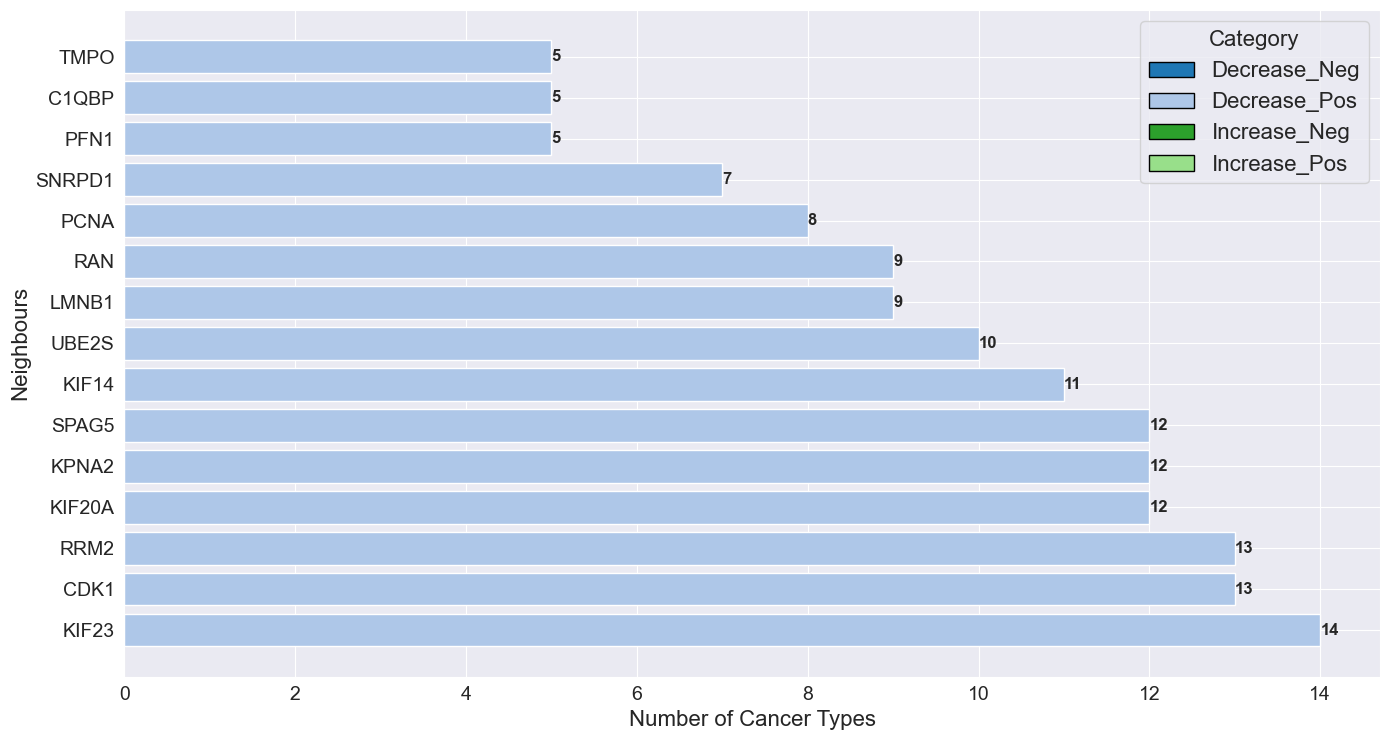


Decrease_Neg:

Decrease_Pos:
  KIF23: 14 cancer types
  CDK1: 13 cancer types
  RRM2: 13 cancer types
  KIF20A: 12 cancer types
  KPNA2: 12 cancer types
  SPAG5: 12 cancer types
  KIF14: 11 cancer types
  UBE2S: 10 cancer types
  LMNB1: 9 cancer types
  RAN: 9 cancer types
  PCNA: 8 cancer types
  SNRPD1: 7 cancer types
  PFN1: 5 cancer types
  C1QBP: 5 cancer types
  TMPO: 5 cancer types

Increase_Neg:

Increase_Pos:


In [66]:
graph_data_filt = []
for neighbour, data in neighbour_trends.items():
    category = categorise_neighbour(data['trends'], data['freq_column'])
    if category != 'Mixed':
        cancer_types = len(data['trends'])
        graph_data_filt.append({
            'Category': category,
            'Neighbour': neighbour,
            'Cancer Types': cancer_types
        })

df_graph_filt = pd.DataFrame(graph_data_filt)
df_graph_filt = df_graph_filt.sort_values(['Category', 'Cancer Types'], ascending=[True, False])

plt.figure(figsize=(14, len(df_graph_filt) * 0.5))  # Increase the figure size

# Define colours for each category
colours = {'Decrease_Neg': '#1f77b4', 'Decrease_Pos': '#aec7e8',
           'Increase_Neg': '#2ca02c', 'Increase_Pos': '#98df8a'}

# Plot the bars
bars = plt.barh(df_graph_filt['Neighbour'], df_graph_filt['Cancer Types'], 
                color=[colours[cat] for cat in df_graph_filt['Category']])

# Add labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center', fontweight='bold', fontsize=12)  # Increase the font size

# Customise the plot
#plt.title('Neighbours by Trend Category and Number of Cancer Types', fontsize=20)  # Increase the font size
plt.xlabel('Number of Cancer Types', fontsize=16)  # Increase the font size
plt.ylabel('Neighbours', fontsize=16)  # Increase the font size
plt.xticks(fontsize=14)  # Increase the font size of x-axis ticks
plt.yticks(fontsize=14)  # Increase the font size of y-axis ticks

# Add a legend
legend_elements = [Patch(facecolor=colours[cat], edgecolor='black', label=cat) 
                   for cat in colours.keys()]
plt.legend(handles=legend_elements, title='Category', loc='upper right', 
           fontsize=16, title_fontsize=16)  # Increase the legend font size

plt.tight_layout()
plt.show()

# Print detailed information
for category in ['Decrease_Neg', 'Decrease_Pos', 'Increase_Neg', 'Increase_Pos']:
    print(f"\n{category}:")
    category_data = df_graph_filt[df_graph_filt['Category'] == category]
    for _, row in category_data.iterrows():
        print(f"  {row['Neighbour']}: {row['Cancer Types']} cancer types")

Of the four possible combinations of effect on survival with sign of correlation with driver mutation status, Decrease_Pos was the only category found in the studied set of neighbours. This category comprises 15 neighbours that show a decrease in patient survival when their expression is high and have a positive association with cancer driver genes.